In [8]:
# Video Inference Analysis: Individual models + Winner-Takes-All Ensemble
# Processes `monuai_model/SG_MBS_Cut.mp4` and records FPS, confidences, predictions.
from ultralytics import YOLO
import cv2
import time
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
import torch
import os

print("Video inference analysis starting...")

PROJECT_DIR = Path('monuai_model')
VIDEO_PATH = PROJECT_DIR / 'SG_MBS_Cut.mp4'
OUT_DIR = PROJECT_DIR / 'video_results' / 'inference_analysis'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Model weight candidates (use whichever exist)
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'original_m': PROJECT_DIR / 'YOLOv11m_teacher' / 'weights' / 'best.pt',
    'ensemble_s': PROJECT_DIR / 'YOLOv11s_ensemble_complement' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

# Load available models
models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            print(f"Loading model: {name} -> {path}")
            models[name] = YOLO(str(path))
        except Exception as e:
            print(f"Failed to load {name}: {e}")
    else:
        print(f"Model not found (skipping): {name}")

if not models:
    raise FileNotFoundError("No model weights found. Train or point to weights first.")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Class names mapping
CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

# Helper IoU
def iou_xyxy(b1, b2):
    x1, y1, x2, y2 = b1
    x3, y3, x4, y4 = b2
    xi1 = max(x1, x3); yi1 = max(y1, y3)
    xi2 = min(x2, x4); yi2 = min(y2, y4)
    if xi2 <= xi1 or yi2 <= yi1:
        return 0.0
    inter = (xi2 - xi1) * (yi2 - yi1)
    a1 = (x2 - x1) * (y2 - y1)
    a2 = (x4 - x3) * (y4 - y3)
    union = a1 + a2 - inter
    return inter / union if union > 0 else 0.0

# Winner-takes-all NMS for predictions across models
from collections import defaultdict

def winner_takes_all(preds, iou_thresh=0.4):
    # preds: list of dicts with keys: 'model','cls','conf','bbox'
    by_cls = defaultdict(list)
    for p in preds:
        by_cls[p['cls']].append(p)
    final = []
    for cls, items in by_cls.items():
        items = sorted(items, key=lambda x: x['conf'], reverse=True)
        selected = []
        for it in items:
            keep = True
            for s in selected:
                if iou_xyxy(it['bbox'], s['bbox']) > iou_thresh:
                    # winner takes all: keep the higher-conf one
                    if it['conf'] > s['conf']:
                        selected.remove(s)
                    else:
                        keep = False
                    break
            if keep:
                selected.append(it)
        final.extend(selected)
    return final

# Processing parameters
FRAME_STEP = 1             # process every frame; increase to skip frames (e.g., 2)
CONF_THRESHOLD = 0.85
IOU_THRESHOLD = 0.5
MAX_DET = 300

# Open video
cap = cv2.VideoCapture(str(VIDEO_PATH))
if not cap.isOpened():
    raise FileNotFoundError(f"Video not found or cannot be opened: {VIDEO_PATH}")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_input = cap.get(cv2.CAP_PROP_FPS) or 30.0

summary_rows = []
per_frame_rows = []

# Prepare video writers for each model
writers = {}
for name in models.keys():
    out_path = OUT_DIR / f"{name}_annotated.mp4"
    writers[name] = cv2.VideoWriter(str(out_path), fourcc, fps_input / FRAME_STEP, (width, height))

# writer for ensemble
ensemble_writer = cv2.VideoWriter(str(OUT_DIR / 'winner_takes_all_ensemble_annotated.mp4'), fourcc, fps_input / FRAME_STEP, (width, height))

frame_idx = 0
processed_frames = 0
start_all = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_idx % FRAME_STEP != 0:
        frame_idx += 1
        continue
    processed_frames += 1
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # store per-model detections this frame
    frame_detections = {}
    frame_annotations = {}

    for name, model in models.items():
        t0 = time.time()
        try:
            results = model.predict(source=frame_rgb, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, max_det=MAX_DET, device=device, verbose=False)
        except Exception as e:
            # fall back to predict on file
            print(f"Model {name} predict error: {e}")
            results = []
        t1 = time.time()
        proc_time = t1 - t0

        dets = []
        if results and len(results) > 0 and getattr(results[0], 'boxes', None) is not None:
            res = results[0]
            for box in res.boxes:
                try:
                    cls = int(box.cls.item())
                    conf = float(box.conf.item())
                    xyxy = box.xyxy[0].tolist()
                except Exception:
                    continue
                dets.append({'cls': cls, 'conf': conf, 'bbox': xyxy})

        frame_detections[name] = dets

        # annotate frame copy
        ann = frame.copy()
        for d in dets:
            x1, y1, x2, y2 = map(int, d['bbox'])
            box_color = (0, 255, 255)  # Yellow bounding box
            cv2.rectangle(ann, (x1, y1), (x2, y2), box_color, 3)

            # Create label with black background and white text
            class_name = CLASS_NAMES.get(d['cls'], f"Class_{d['cls']}")
            label_text = f"{class_name}:{d['conf']:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.6
            font_thickness = 2

            # Get text size for background rectangle
            (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
            label_y = max(y1 - 10, text_height + 10)

            # Draw black background rectangle
            cv2.rectangle(ann, (x1, label_y - text_height - 8), (x1 + text_width + 8, label_y + 4), (0, 0, 0), -1)

            # Draw white text
            cv2.putText(ann, label_text, (x1 + 4, label_y - 4), font, font_scale, (255, 255, 255), font_thickness)

        # write annotated frame
        writers[name].write(ann)

        # collect per-frame metrics
        num_preds = len(dets)
        avg_conf = float(np.mean([d['conf'] for d in dets])) if dets else 0.0
        max_conf = float(np.max([d['conf'] for d in dets])) if dets else 0.0

        per_frame_rows.append({
            'frame': processed_frames,
            'model': name,
            'num_preds': num_preds,
            'avg_conf': avg_conf,
            'max_conf': max_conf,
            'proc_time_s': proc_time,
            'fps': 1.0 / proc_time if proc_time > 0 else 0.0,
            'class_names': [CLASS_NAMES.get(d['cls'], f"Class_{d['cls']}") for d in dets]
        })

    # Ensemble (winner-takes-all) per frame
    all_preds = []
    for name, dets in frame_detections.items():
        for d in dets:
            all_preds.append({'model': name, 'cls': d['cls'], 'conf': d['conf'], 'bbox': d['bbox']})

    ensemble_preds = winner_takes_all(all_preds, iou_thresh=IOU_THRESHOLD)

    # Annotate and write ensemble video
    ann_e = frame.copy()
    for d in ensemble_preds:
        x1, y1, x2, y2 = map(int, d['bbox'])
        box_color = (0, 255, 255)  # Yellow bounding box
        cv2.rectangle(ann_e, (x1, y1), (x2, y2), box_color, 3)

        # Create label with black background and white text
        class_name = CLASS_NAMES.get(d['cls'], f"Class_{d['cls']}")
        label_text = f"{class_name}:{d['conf']:.2f}:{d['model']}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 2

        # Get text size for background rectangle
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        label_y = max(y1 - 10, text_height + 10)

        # Draw black background rectangle
        cv2.rectangle(ann_e, (x1, label_y - text_height - 8), (x1 + text_width + 8, label_y + 4), (0, 0, 0), -1)

        # Draw white text
        cv2.putText(ann_e, label_text, (x1 + 4, label_y - 4), font, font_scale, (255, 255, 255), font_thickness)

    ensemble_writer.write(ann_e)

    # collect ensemble metrics
    num_preds = len(ensemble_preds)
    avg_conf = float(np.mean([d['conf'] for d in ensemble_preds])) if ensemble_preds else 0.0
    max_conf = float(np.max([d['conf'] for d in ensemble_preds])) if ensemble_preds else 0.0
    # approximate ensemble proc time as sum of model times measured earlier for this frame
    proc_time_sum = sum([row['proc_time_s'] for row in per_frame_rows[-len(models):]]) if len(models)>0 else 0.0

    per_frame_rows.append({
        'frame': processed_frames,
        'model': 'winner_takes_all_ensemble',
        'num_preds': num_preds,
        'avg_conf': avg_conf,
        'max_conf': max_conf,
        'proc_time_s': proc_time_sum,
        'fps': 1.0 / proc_time_sum if proc_time_sum > 0 else 0.0,
        'class_names': [CLASS_NAMES.get(d['cls'], f"Class_{d['cls']}") for d in ensemble_preds]
    })

    frame_idx += 1

# release resources
cap.release()
for w in writers.values():
    w.release()
ensemble_writer.release()
end_all = time.time()

# Convert per-frame list to DataFrame and compute summaries
df = pd.DataFrame(per_frame_rows)
summary = df.groupby('model').agg(
    total_frames=('frame', 'count'),
    avg_preds_per_frame=('num_preds', 'mean'),
    avg_conf=('avg_conf', 'mean'),
    avg_max_conf=('max_conf', 'mean'),
    avg_fps=('fps', 'mean')
).reset_index()

# Save outputs
csv_per_frame = OUT_DIR / 'per_frame_inference.csv'
csv_summary = OUT_DIR / 'inference_summary.csv'

df.to_csv(csv_per_frame, index=False)
summary.to_csv(csv_summary, index=False)

print('\nInference analysis complete')
print(f'  Processed frames: {processed_frames}')
print(f'  Outputs written to: {OUT_DIR}')
print(f'  Per-frame CSV: {csv_per_frame}')
print(f'  Summary CSV: {csv_summary}')

# Display summary
print('\nSummary:')
print(summary.to_string(index=False))

# Final note: annotated videos are in OUT_DIR, filenames contain model keys and ensemble result.


Video inference analysis starting...
Loading model: enhanced_m -> monuai_model\YOLOv11m_teacher_enhanced\weights\best.pt
Loading model: original_m -> monuai_model\YOLOv11m_teacher\weights\best.pt
Loading model: ensemble_s -> monuai_model\YOLOv11s_ensemble_complement\weights\best.pt
Loading model: student_optimized -> monuai_model\yolov11n_student_optimized\weights\best.pt
Device: cuda

Inference analysis complete
  Processed frames: 2280
  Outputs written to: monuai_model\video_results\inference_analysis
  Per-frame CSV: monuai_model\video_results\inference_analysis\per_frame_inference.csv
  Summary CSV: monuai_model\video_results\inference_analysis\inference_summary.csv

Summary:
                    model  total_frames  avg_preds_per_frame  avg_conf  avg_max_conf    avg_fps
               enhanced_m          2280             0.930263  0.597294      0.600995  77.573701
               ensemble_s          2280             0.780702  0.486214      0.488324 126.265935
               origina

In [9]:
# Combine All Model Videos into Single Comparison Video
import cv2
import numpy as np
from pathlib import Path
import os

print("Creating combined comparison video...")

OUT_DIR = Path('monuai_model') / 'video_results' / 'inference_analysis'
COMBINED_OUTPUT = OUT_DIR / 'all_models_comparison.mp4'

# Find all annotated videos
video_files = []
video_caps = []
video_names = []

# Look for individual model videos
for video_file in OUT_DIR.glob("*_annotated.mp4"):
    if video_file.name != 'all_models_comparison.mp4':  # Skip our output file
        video_files.append(video_file)
        cap = cv2.VideoCapture(str(video_file))
        if cap.isOpened():
            video_caps.append(cap)
            # Extract model name from filename
            model_name = video_file.stem.replace('_annotated', '')
            if model_name == 'winner_takes_all_ensemble':
                model_name = 'Ensemble'
            elif model_name == 'enhanced_m':
                model_name = 'Enhanced YOLOv11m'
            elif model_name == 'original_m':
                model_name = 'Original YOLOv11m'
            elif model_name == 'ensemble_s':
                model_name = 'YOLOv11s'
            elif model_name == 'student_optimized':
                model_name = 'Student YOLOv11n'
            video_names.append(model_name)
            print(f"Found video: {model_name}")
        else:
            print(f"Could not open: {video_file}")

if not video_caps:
    print("No annotated videos found to combine!")
else:
    # Get video properties from first video
    first_cap = video_caps[0]
    width = int(first_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(first_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = first_cap.get(cv2.CAP_PROP_FPS) or 30.0
    
    # Determine grid layout
    num_videos = len(video_caps)
    if num_videos == 1:
        grid_cols, grid_rows = 1, 1
    elif num_videos == 2:
        grid_cols, grid_rows = 2, 1
    elif num_videos <= 4:
        grid_cols, grid_rows = 2, 2
    elif num_videos <= 6:
        grid_cols, grid_rows = 3, 2
    else:
        grid_cols, grid_rows = 3, 3
    
    # Calculate output dimensions
    cell_width = width // 2  # Make each cell smaller for better viewing
    cell_height = height // 2
    output_width = grid_cols * cell_width
    output_height = grid_rows * cell_height
    
    print(f"Creating {grid_cols}x{grid_rows} grid layout")
    print(f"Output resolution: {output_width}x{output_height}")
    
    # Create output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(str(COMBINED_OUTPUT), fourcc, fps, (output_width, output_height))
    
    frame_count = 0
    while True:
        frames = []
        all_frames_read = True
        
        # Read frame from each video
        for cap in video_caps:
            ret, frame = cap.read()
            if not ret:
                all_frames_read = False
                break
            # Resize frame to fit grid cell
            resized_frame = cv2.resize(frame, (cell_width, cell_height))
            frames.append(resized_frame)
        
        if not all_frames_read or len(frames) != num_videos:
            break
        
        # Create combined frame
        combined_frame = np.zeros((output_height, output_width, 3), dtype=np.uint8)
        
        for i, (frame, name) in enumerate(zip(frames, video_names)):
            # Calculate position in grid
            row = i // grid_cols
            col = i % grid_cols
            
            # Calculate pixel coordinates
            y_start = row * cell_height
            y_end = y_start + cell_height
            x_start = col * cell_width
            x_end = x_start + cell_width
            
            # Place frame in grid
            combined_frame[y_start:y_end, x_start:x_end] = frame
            
            # Add model name label
            label_y = y_start + 25
            label_x = x_start + 10
            cv2.putText(combined_frame, name, (label_x, label_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(combined_frame, name, (label_x, label_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
        
        # Write combined frame
        out_writer.write(combined_frame)
        frame_count += 1
        
        if frame_count % 30 == 0:  # Progress update every 30 frames
            print(f"Processed {frame_count} frames...")
    
    # Release resources
    for cap in video_caps:
        cap.release()
    out_writer.release()
    
    print(f"\nCombined video created successfully!")
    print(f"Output: {COMBINED_OUTPUT}")
    print(f"Total frames processed: {frame_count}")
    print(f"Grid layout: {grid_cols}x{grid_rows} ({len(video_names)} models)")
    print(f"Models included: {', '.join(video_names)}")
    
    # Create a summary of what's in the combined video
    print(f"\nCombined Video Layout:")
    for i, name in enumerate(video_names):
        row = i // grid_cols
        col = i % grid_cols
        position = f"Row {row+1}, Column {col+1}"
        print(f"  {position}: {name}")

Creating combined comparison video...
Found video: Enhanced YOLOv11m
Found video: YOLOv11s
Found video: Original YOLOv11m
Found video: Student YOLOv11n
Found video: Ensemble
Creating 3x2 grid layout
Output resolution: 2880x1080
Processed 30 frames...
Processed 30 frames...
Processed 60 frames...
Processed 60 frames...
Processed 90 frames...
Processed 90 frames...
Processed 120 frames...
Processed 120 frames...
Processed 150 frames...
Processed 150 frames...
Processed 180 frames...
Processed 180 frames...
Processed 210 frames...
Processed 210 frames...
Processed 240 frames...
Processed 240 frames...
Processed 270 frames...
Processed 270 frames...
Processed 300 frames...
Processed 300 frames...
Processed 330 frames...
Processed 330 frames...
Processed 360 frames...
Processed 360 frames...
Processed 390 frames...
Processed 390 frames...
Processed 420 frames...
Processed 420 frames...
Processed 450 frames...
Processed 450 frames...
Processed 480 frames...
Processed 480 frames...
Processed 

Starting Grad-CAM VIDEO analysis for model interpretability...
Loading model for Grad-CAM: enhanced_m
Loading model for Grad-CAM: student_optimized
Processing video: monuai_model\SG_MBS_Cut.mp4
Video properties: 1920x1080, 30.0 FPS, 2280 frames
Processing video frames...
Processing video: monuai_model\SG_MBS_Cut.mp4
Video properties: 1920x1080, 30.0 FPS, 2280 frames
Processing video frames...
Processed 30/2280 frames | Processing FPS: 5.6 | ETA: 405.0s
Processed 30/2280 frames | Processing FPS: 5.6 | ETA: 405.0s
Processed 60/2280 frames | Processing FPS: 5.3 | ETA: 417.2s
Processed 60/2280 frames | Processing FPS: 5.3 | ETA: 417.2s
Processed 90/2280 frames | Processing FPS: 5.3 | ETA: 412.6s
Processed 90/2280 frames | Processing FPS: 5.3 | ETA: 412.6s
Processed 120/2280 frames | Processing FPS: 5.4 | ETA: 399.0s
Processed 120/2280 frames | Processing FPS: 5.4 | ETA: 399.0s
Processed 150/2280 frames | Processing FPS: 5.5 | ETA: 388.3s
Processed 150/2280 frames | Processing FPS: 5.5 | ET

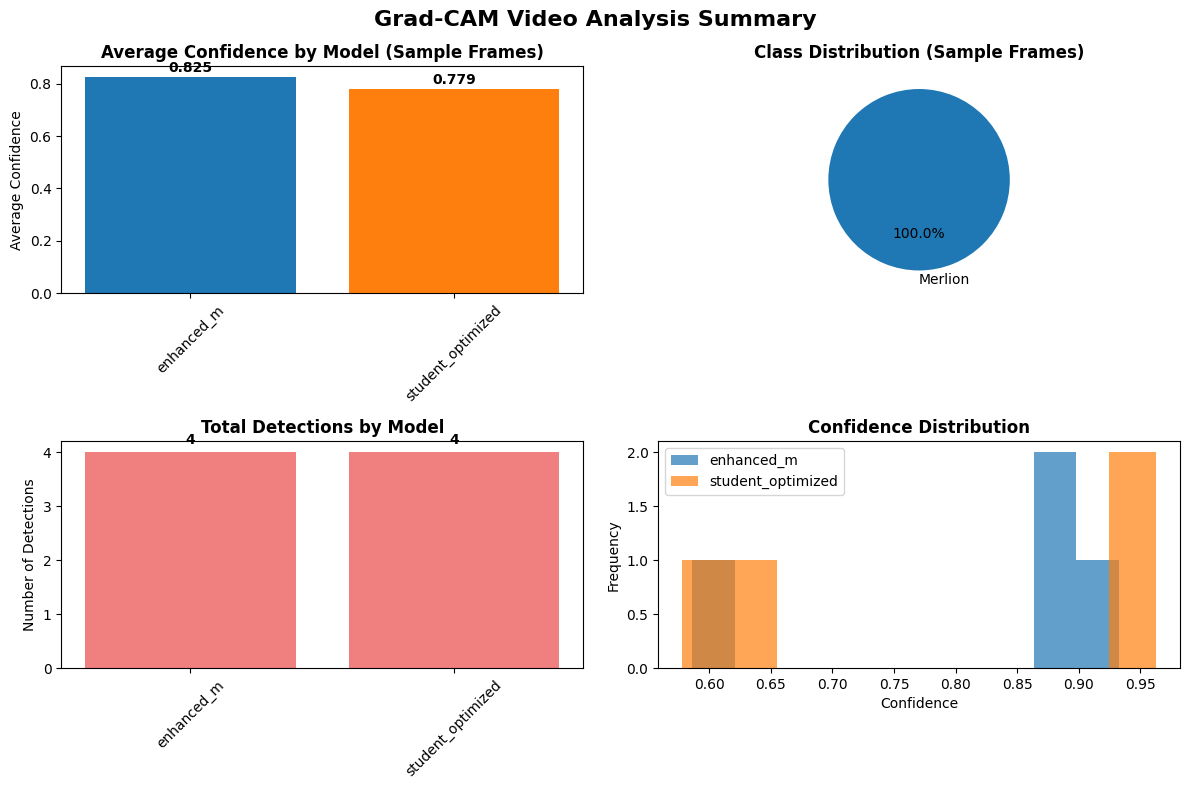

Summary saved: monuai_model\gradcam_output\gradcam_video_summary.png
CSV saved: monuai_model\gradcam_output\gradcam_video_analysis.csv

Grad-CAM VIDEO analysis ready to run!
This will generate video outputs showing:
   Pure heatmap videos: Clean attention maps with model statistics
     - Model name and type clearly displayed
     - Frame number and detection count
     - Average and maximum confidence scores
     - Attention intensity metrics
     - Detected landmark classes
   Subtle overlay videos: Original video with light attention overlays
   Comparison videos: Side-by-side model behavior analysis
   No bounding boxes or predictions - pure attention focus
   Real-time statistics embedded in video frames

 Processing parameters:
  Frame step: 1 (1 = every frame)
  Max frames: All frames
  Confidence threshold: 0.3


In [12]:
# Grad-CAM Video Analysis for Model Interpretability
# Creates videos showing attention heatmaps overlaid on the original video
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F
from ultralytics import YOLO
import seaborn as sns
from PIL import Image
import time

print("Starting Grad-CAM VIDEO analysis for model interpretability...")

PROJECT_DIR = Path('monuai_model')
OUT_DIR = PROJECT_DIR / 'gradcam_output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Video processing parameters
FRAME_STEP = 1  # Process every frame (increase to skip frames for faster processing)
MAX_FRAMES = None  # Set to limit frames (e.g., 300) or None for full video

# Load models for analysis
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            print(f"Loading model for Grad-CAM: {name}")
            models[name] = YOLO(str(path))
        except Exception as e:
            print(f"Failed to load {name}: {e}")

if not models:
    print("No models available for Grad-CAM analysis")
else:
    # Class names for interpretation
    CLASS_NAMES = {
        0: 'ArtScience Museum',
        1: 'Esplanade', 
        2: 'Marina Bay Sands',
        3: 'Merlion'
    }

    def create_pure_heatmap_frame(heatmap, model_name, detections, frame_idx, width, height):
        """Create pure heatmap frame with model name and statistics"""
        if heatmap is None:
            # Create black frame if no heatmap
            heatmap_frame = np.zeros((height, width, 3), dtype=np.uint8)
        else:
            # Normalize heatmap to 0-255 range
            heatmap_norm = (heatmap * 255).astype(np.uint8)
            # Apply colormap to heatmap
            heatmap_frame = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
        
        # Add model information overlay
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Model name at top
        model_display_name = model_name.replace('_', ' ').title()
        if 'Enhanced' in model_display_name:
            model_display_name = "Enhanced YOLOv11m Teacher"
        elif 'Student' in model_display_name:
            model_display_name = "Student YOLOv11n (Distilled)"
        
        # Add semi-transparent background for text
        overlay = heatmap_frame.copy()
        cv2.rectangle(overlay, (10, 10), (width-10, 120), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.7, heatmap_frame, 0.3, 0, heatmap_frame)
        
        # Model name (large)
        cv2.putText(heatmap_frame, model_display_name, (20, 40), 
                   font, 1.0, (255, 255, 255), 2)
        
        # Statistics
        num_detections = len(detections)
        avg_confidence = np.mean([d['confidence'] for d in detections]) if detections else 0.0
        max_confidence = np.max([d['confidence'] for d in detections]) if detections else 0.0
        
        stats_text = f"Frame: {frame_idx:4d} | Detections: {num_detections:2d}"
        cv2.putText(heatmap_frame, stats_text, (20, 70), 
                   font, 0.6, (200, 200, 200), 1)
        
        confidence_text = f"Avg Conf: {avg_confidence:.3f} | Max Conf: {max_confidence:.3f}"
        cv2.putText(heatmap_frame, confidence_text, (20, 95), 
                   font, 0.6, (200, 200, 200), 1)
        
        # Add attention intensity indicator
        if heatmap is not None:
            attention_intensity = float(np.mean(heatmap))
            intensity_text = f"Attention Intensity: {attention_intensity:.3f}"
            cv2.putText(heatmap_frame, intensity_text, (20, 120), 
                       font, 0.5, (255, 255, 0), 1)
        
        # Add detected classes (bottom of frame)
        if detections:
            detected_classes = list(set([d['class_name'] for d in detections]))
            classes_text = "Detected: " + ", ".join(detected_classes)
            
            # Background for bottom text
            text_size = cv2.getTextSize(classes_text, font, 0.6, 1)[0]
            cv2.rectangle(heatmap_frame, (10, height-40), (text_size[0]+20, height-10), (0, 0, 0), -1)
            cv2.putText(heatmap_frame, classes_text, (15, height-20), 
                       font, 0.6, (255, 255, 255), 1)
        
        return heatmap_frame

    def create_heatmap_overlay_frame(original_frame, heatmap, detections, model_name, frame_idx, alpha=0.4):
        """Create frame with subtle heatmap overlay and model info (no bounding boxes)"""
        if heatmap is None:
            overlay_frame = original_frame.copy()
        else:
            # Normalize heatmap to 0-255 range
            heatmap_norm = (heatmap * 255).astype(np.uint8)
            # Apply colormap to heatmap
            heatmap_colored = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
            # Blend original frame with heatmap
            overlay_frame = cv2.addWeighted(original_frame, 1-alpha, heatmap_colored, alpha, 0)
        
        # Add model information (same as pure heatmap but smaller)
        font = cv2.FONT_HERSHEY_SIMPLEX
        height, width = overlay_frame.shape[:2]
        
        model_display_name = model_name.replace('_', ' ').title()
        if 'Enhanced' in model_display_name:
            model_display_name = "Enhanced YOLOv11m"
        elif 'Student' in model_display_name:
            model_display_name = "Student YOLOv11n"
        
        # Compact info overlay
        cv2.rectangle(overlay_frame, (10, 10), (400, 60), (0, 0, 0), -1)
        cv2.addWeighted(overlay_frame[10:60, 10:400], 0.3, 
                       np.zeros((50, 390, 3), dtype=np.uint8), 0.7, 0, overlay_frame[10:60, 10:400])
        
        # Model name and basic stats
        cv2.putText(overlay_frame, f"{model_display_name} | Frame: {frame_idx}", (15, 30), 
                   font, 0.6, (255, 255, 255), 1)
        
        num_detections = len(detections)
        avg_conf = np.mean([d['confidence'] for d in detections]) if detections else 0.0
        cv2.putText(overlay_frame, f"Detections: {num_detections} | Avg Conf: {avg_conf:.3f}", (15, 50), 
                   font, 0.5, (200, 200, 200), 1)
        
        return overlay_frame

    def simple_gradcam_yolo(model, image, target_class=None, conf_threshold=0.5):
        """
        Simplified Grad-CAM for YOLO models
        Since YOLO models are complex, we'll use feature map visualization
        """
        try:
            # Get model predictions
            results = model.predict(source=image, conf=conf_threshold, verbose=False)
            
            if not results or len(results) == 0:
                return None, None, []
            
            result = results[0]
            detections = []
            
            if hasattr(result, 'boxes') and result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls.item())
                    conf = float(box.conf.item())
                    xyxy = box.xyxy[0].tolist()
                    detections.append({
                        'class': cls,
                        'confidence': conf,
                        'bbox': xyxy,
                        'class_name': CLASS_NAMES.get(cls, f"Class_{cls}")
                    })
            
            # Create attention heatmap based on detection confidence and size
            h, w = image.shape[:2]
            heatmap = np.zeros((h, w), dtype=np.float32)
            
            for det in detections:
                x1, y1, x2, y2 = map(int, det['bbox'])
                confidence = det['confidence']
                
                # Create gaussian-like attention around detection
                center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                bbox_w, bbox_h = x2 - x1, y2 - y1
                
                # Create 2D gaussian centered at detection
                y_coords, x_coords = np.ogrid[:h, :w]
                sigma_x, sigma_y = bbox_w // 4, bbox_h // 4
                
                if sigma_x > 0 and sigma_y > 0:
                    gaussian = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                      (y_coords - center_y)**2 / (2 * sigma_y**2)))
                    heatmap += gaussian * confidence
            
            # Normalize heatmap
            if heatmap.max() > 0:
                heatmap = heatmap / heatmap.max()
            
            return heatmap, result, detections
            
        except Exception as e:
            print(f"Error in Grad-CAM analysis: {e}")
            return None, None, []

    def create_gradcam_visualization(image, heatmap, detections, model_name):
        """Create comprehensive Grad-CAM visualization"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image with detections
        axes[0].imshow(image)
        axes[0].set_title(f'{model_name} - Detections', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, color='yellow', linewidth=3)
            axes[0].add_patch(rect)
            
            # Add label
            label = f"{det['class_name']}\n{det['confidence']:.2f}"
            axes[0].text(x1, y1-10, label, fontsize=10, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7),
                        color='white', fontweight='bold')
        
        # Heatmap
        if heatmap is not None:
            hm = axes[1].imshow(heatmap, cmap='jet', alpha=0.8)
            axes[1].set_title(f'{model_name} - Attention Heatmap', fontsize=14, fontweight='bold')
            axes[1].axis('off')
            plt.colorbar(hm, ax=axes[1], fraction=0.046, pad=0.04)
        else:
            axes[1].text(0.5, 0.5, 'No Heatmap\nGenerated', 
                        ha='center', va='center', fontsize=16,
                        transform=axes[1].transAxes)
            axes[1].set_title(f'{model_name} - No Attention', fontsize=14)
            axes[1].axis('off')
        
        # Overlay
        axes[2].imshow(image)
        if heatmap is not None:
            axes[2].imshow(heatmap, cmap='jet', alpha=0.4)
        axes[2].set_title(f'{model_name} - Overlay', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        
        # Add detection boxes to overlay
        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, color='white', linewidth=2)
            axes[2].add_patch(rect)
        
        plt.tight_layout()
        return fig

    def process_video_gradcam(video_path, models, output_dir):
        """Process entire video with Grad-CAM analysis"""
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"Cannot open video: {video_path}")
            return False
        
        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
        
        # Setup video writers for each model
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writers = {}
        
        # Individual model videos (pure heatmaps and overlays)
        for model_name in models.keys():
            # Pure heatmap video
            out_path = output_dir / f'gradcam_{model_name}_pure_heatmap.mp4'
            writers[f'{model_name}_pure'] = cv2.VideoWriter(str(out_path), fourcc, fps/FRAME_STEP, (width, height))
            
            # Subtle overlay video
            out_path = output_dir / f'gradcam_{model_name}_subtle_overlay.mp4'
            writers[f'{model_name}_overlay'] = cv2.VideoWriter(str(out_path), fourcc, fps/FRAME_STEP, (width, height))
        
        # Combined comparison videos
        comparison_width = width * len(models)
        comparison_height = height
        
        # Pure heatmap comparison
        pure_comp_path = output_dir / 'gradcam_pure_heatmaps_comparison.mp4'
        pure_comparison_writer = cv2.VideoWriter(str(pure_comp_path), fourcc, fps/FRAME_STEP, (comparison_width, comparison_height))
        
        # Overlay comparison
        overlay_comp_path = output_dir / 'gradcam_overlays_comparison.mp4'
        overlay_comparison_writer = cv2.VideoWriter(str(overlay_comp_path), fourcc, fps/FRAME_STEP, (comparison_width, comparison_height))
        
        frame_count = 0
        processed_frames = 0
        start_time = time.time()
        
        print("Processing video frames...")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count % FRAME_STEP != 0:
                frame_count += 1
                continue
            
            if MAX_FRAMES and processed_frames >= MAX_FRAMES:
                break
            
            # Convert to RGB for model processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Process frame with each model
            model_results = {}
            pure_frames = []
            overlay_frames = []
            
            for model_name, model in models.items():
                heatmap, result, detections = simple_gradcam_yolo(model, frame_rgb, conf_threshold=0.3)
                model_results[model_name] = {'heatmap': heatmap, 'detections': detections}
                
                # Create pure heatmap frame with statistics
                pure_frame = create_pure_heatmap_frame(heatmap, model_name, detections, processed_frames, width, height)
                writers[f'{model_name}_pure'].write(pure_frame)
                pure_frames.append(pure_frame)
                
                # Create subtle overlay frame 
                overlay_frame = create_heatmap_overlay_frame(frame, heatmap, detections, model_name, processed_frames, alpha=0.4)
                writers[f'{model_name}_overlay'].write(overlay_frame)
                overlay_frames.append(overlay_frame)
            
            # Create comparison frames
            if pure_frames:
                pure_comparison_frame = np.hstack(pure_frames)
                pure_comparison_writer.write(pure_comparison_frame)
            
            if overlay_frames:
                overlay_comparison_frame = np.hstack(overlay_frames)
                overlay_comparison_writer.write(overlay_comparison_frame)
            
            processed_frames += 1
            frame_count += 1
            
            # Progress update
            if processed_frames % 30 == 0:
                elapsed = time.time() - start_time
                fps_processing = processed_frames / elapsed
                eta = (total_frames - processed_frames) / fps_processing if fps_processing > 0 else 0
                print(f"Processed {processed_frames}/{total_frames} frames | "
                      f"Processing FPS: {fps_processing:.1f} | ETA: {eta:.1f}s")
        
        # Release resources
        cap.release()
        for writer in writers.values():
            writer.release()
        pure_comparison_writer.release()
        overlay_comparison_writer.release()
        
        elapsed = time.time() - start_time
        print(f"\nVideo processing completed!")
        print(f"Total frames processed: {processed_frames}")
        print(f"Processing time: {elapsed:.1f}s")
        print(f"Average processing FPS: {processed_frames/elapsed:.1f}")
        
        return True

    # Process the full video with Grad-CAM analysis
    VIDEO_PATH = PROJECT_DIR / 'SG_MBS_Cut.mp4'
    if VIDEO_PATH.exists():
        print(f"Processing video: {VIDEO_PATH}")
        
        success = process_video_gradcam(VIDEO_PATH, models, OUT_DIR)
        
        if success:
            print(f"\n Grad-CAM Video Analysis Complete!")
            print(f" Output directory: {OUT_DIR}")
            
            print(f"\n Generated video files:")
            for video_file in sorted(OUT_DIR.glob('gradcam_*.mp4')):
                print(f"   {video_file.name}")
            
            print(f"\n Video types generated:")
            print(f"   Pure heatmap videos: Clean attention maps with model info and stats")
            print(f"   Subtle overlay videos: Original video with light attention overlay") 
            print(f"   Comparison videos: Side-by-side model behavior")
            print(f"     - Pure heatmaps comparison: Direct attention comparison")
            print(f"     - Overlays comparison: Context-aware attention comparison")
            
            # Create analysis summary from a few sample frames
            print(f"\nCreating sample frame analysis...")
            cap = cv2.VideoCapture(str(VIDEO_PATH))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Sample a few frames for detailed analysis
            sample_indices = [
                total_frames // 4,
                total_frames // 2, 
                3 * total_frames // 4
            ]
            
            confidence_data = []
            for i, frame_idx in enumerate(sample_indices):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    for model_name, model in models.items():
                        heatmap, result, detections = simple_gradcam_yolo(model, frame_rgb, conf_threshold=0.3)
                        
                        for det in detections:
                            confidence_data.append({
                                'sample_frame': i+1,
                                'frame_index': frame_idx,
                                'model': model_name,
                                'class': det['class_name'],
                                'confidence': det['confidence']
                            })
            
            cap.release()
            
            # Create summary if we have data
            if confidence_data:
                import pandas as pd
                df_conf = pd.DataFrame(confidence_data)
                
                plt.figure(figsize=(12, 8))
                
                # Model confidence comparison
                plt.subplot(2, 2, 1)
                model_conf = df_conf.groupby('model')['confidence'].mean()
                bars = plt.bar(model_conf.index, model_conf.values, color=['#1f77b4', '#ff7f0e'])
                plt.title('Average Confidence by Model (Sample Frames)', fontweight='bold')
                plt.ylabel('Average Confidence')
                plt.xticks(rotation=45)
                
                for bar, value in zip(bars, model_conf.values):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
                
                # Class distribution
                plt.subplot(2, 2, 2)
                class_dist = df_conf.groupby('class').size()
                plt.pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
                plt.title('Class Distribution (Sample Frames)', fontweight='bold')
                
                # Detection counts per model
                plt.subplot(2, 2, 3)
                det_count = df_conf.groupby('model').size()
                bars = plt.bar(det_count.index, det_count.values, color='lightcoral')
                plt.title('Total Detections by Model', fontweight='bold')
                plt.ylabel('Number of Detections')
                plt.xticks(rotation=45)
                
                for bar, value in zip(bars, det_count.values):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                           f'{value}', ha='center', va='bottom', fontweight='bold')
                
                # Confidence distribution
                plt.subplot(2, 2, 4)
                for model_name in df_conf['model'].unique():
                    model_data = df_conf[df_conf['model'] == model_name]
                    plt.hist(model_data['confidence'], alpha=0.7, label=model_name, bins=10)
                plt.title('Confidence Distribution', fontweight='bold')
                plt.xlabel('Confidence')
                plt.ylabel('Frequency')
                plt.legend()
                
                plt.suptitle('Grad-CAM Video Analysis Summary', fontsize=16, fontweight='bold')
                plt.tight_layout()
                
                summary_path = OUT_DIR / 'gradcam_video_summary.png'
                plt.savefig(summary_path, dpi=150, bbox_inches='tight')
                plt.show()
                
                # Save detailed CSV
                csv_path = OUT_DIR / 'gradcam_video_analysis.csv'
                df_conf.to_csv(csv_path, index=False)
                print(f"Summary saved: {summary_path}")
                print(f"CSV saved: {csv_path}")
                
        else:
            print(" Failed to process video")
            
    else:
        print(f"Video not found: {VIDEO_PATH}")
        print("Please ensure the video file exists in the project directory")

print("\nGrad-CAM VIDEO analysis ready to run!")
print("This will generate video outputs showing:")
print("   Pure heatmap videos: Clean attention maps with model statistics")
print("     - Model name and type clearly displayed")
print("     - Frame number and detection count")
print("     - Average and maximum confidence scores")
print("     - Attention intensity metrics")
print("     - Detected landmark classes")
print("   Subtle overlay videos: Original video with light attention overlays") 
print("   Comparison videos: Side-by-side model behavior analysis")
print("   No bounding boxes or predictions - pure attention focus")
print("   Real-time statistics embedded in video frames")
print("\n Processing parameters:")
print(f"  Frame step: {FRAME_STEP} (1 = every frame)")
print(f"  Max frames: {MAX_FRAMES or 'All frames'}")
print("  Confidence threshold: 0.3")

 Advanced Model Visualization & Evaluation Suite
Loading model: enhanced_m
Loading model: student_optimized
 Starting Comprehensive Model Analysis...
Video: monuai_model\SG_MBS_Cut.mp4
Models: ['enhanced_m', 'student_optimized']
 Creating Prediction Dashboard...
Running confidence analysis...
 Analyzing Confidence Distributions...


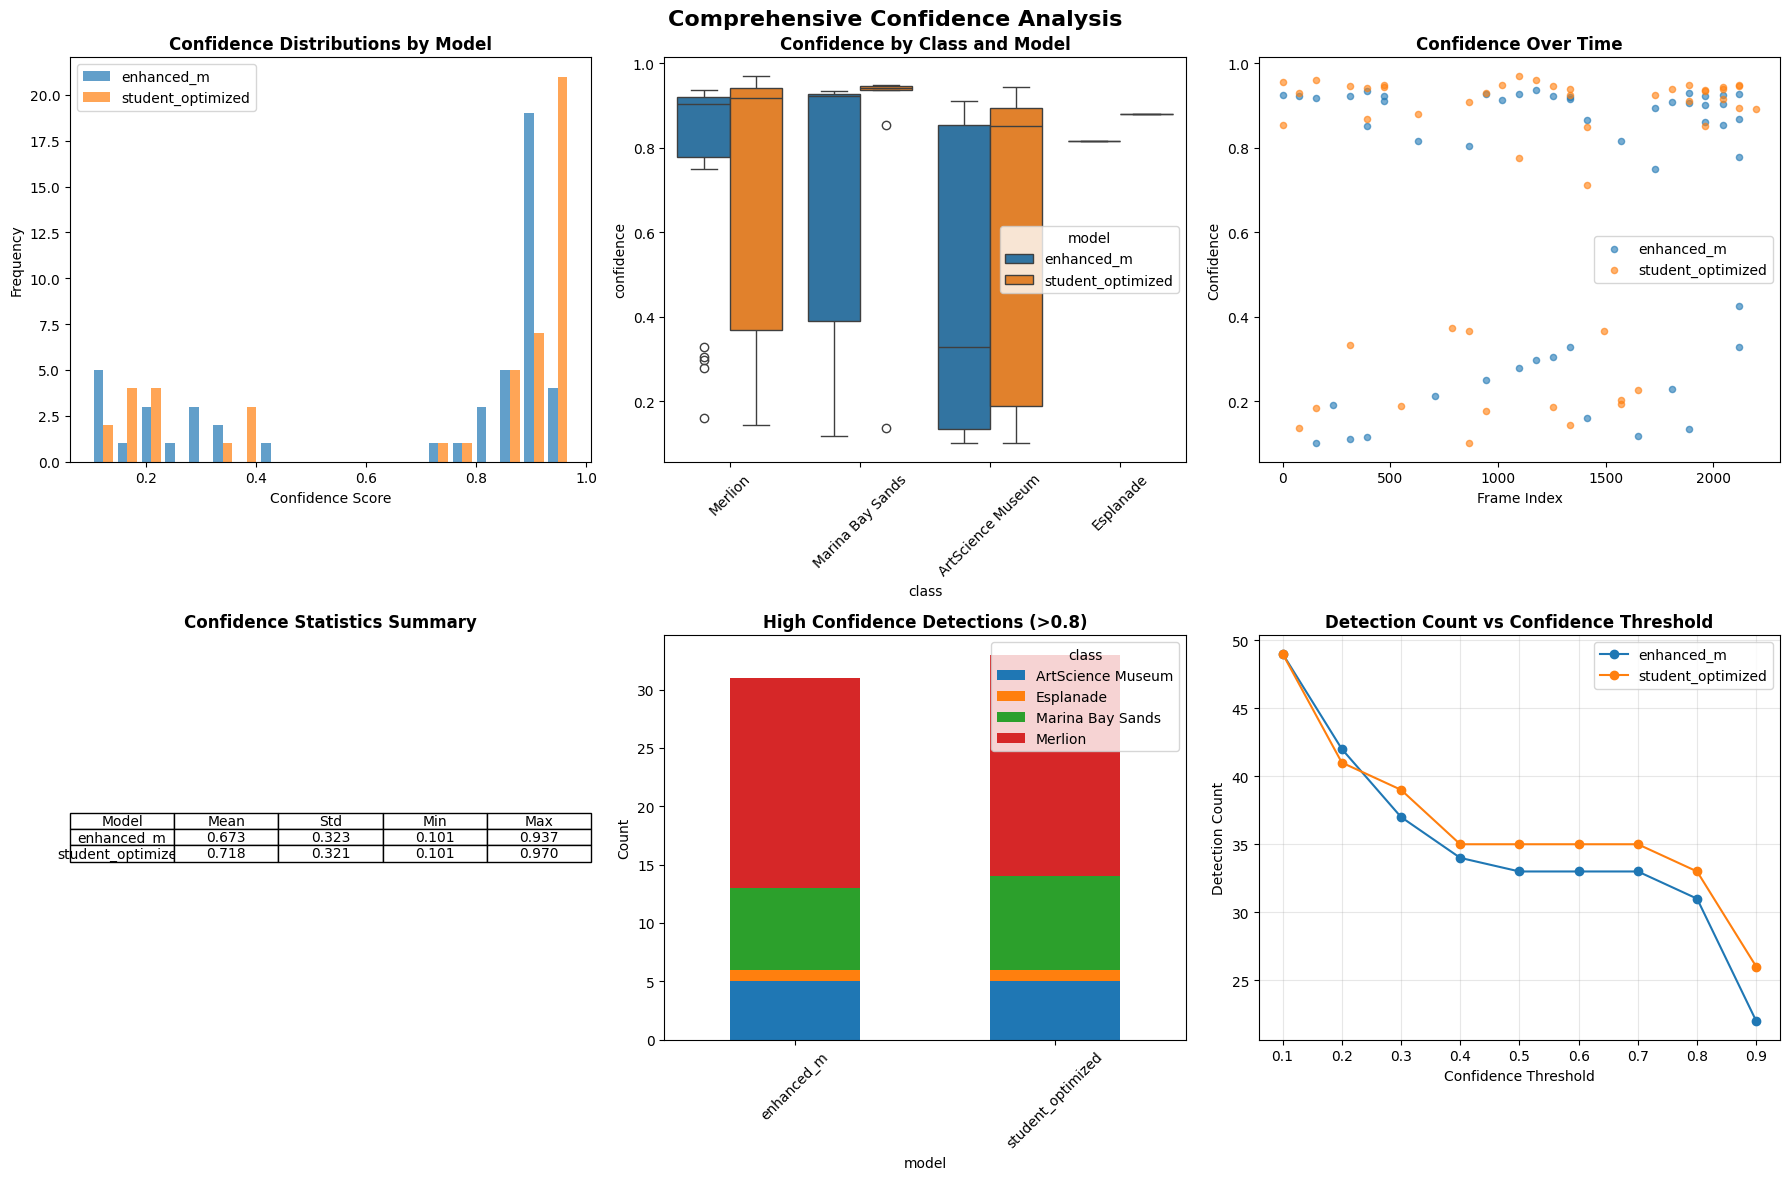

 Confidence analysis saved: monuai_model\advanced_analysis\confidence_analysis.png
Running detection pattern analysis...
 Analyzing Detection Patterns...


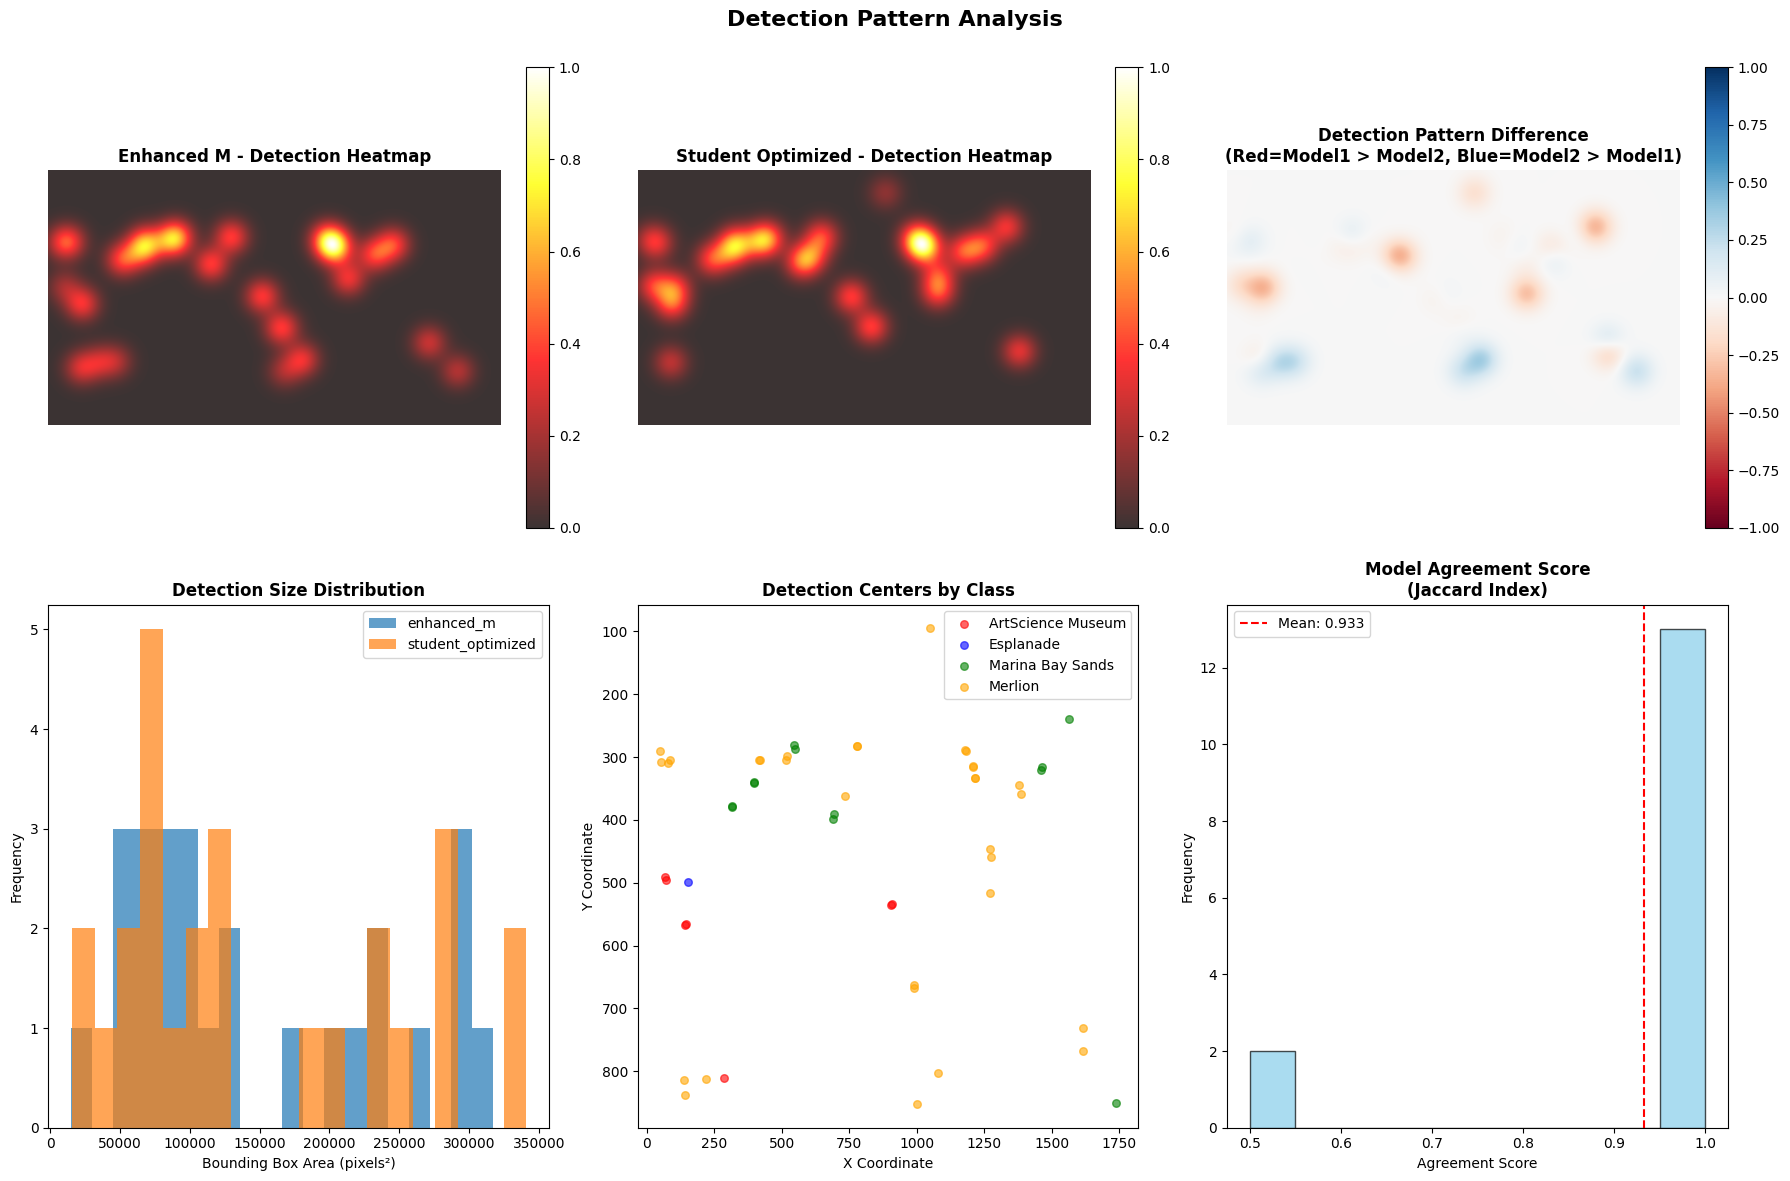

 Detection pattern analysis saved: monuai_model\advanced_analysis\detection_patterns.png
Running stability analysis...
 Analyzing Prediction Stability...


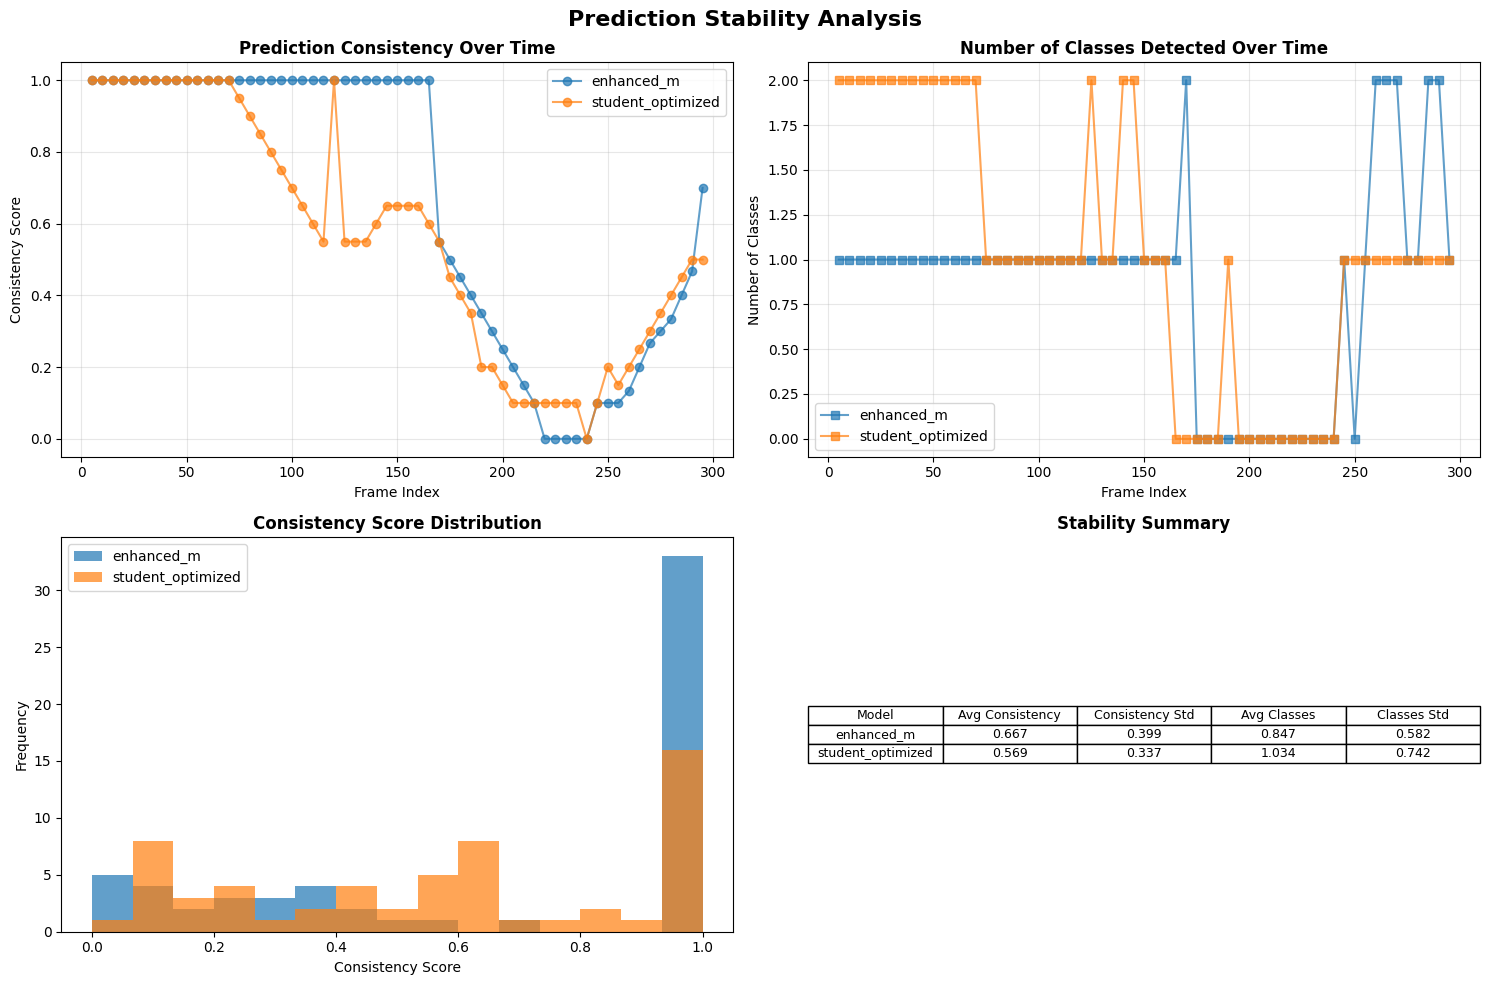

 Stability analysis saved: monuai_model\advanced_analysis\prediction_stability.png


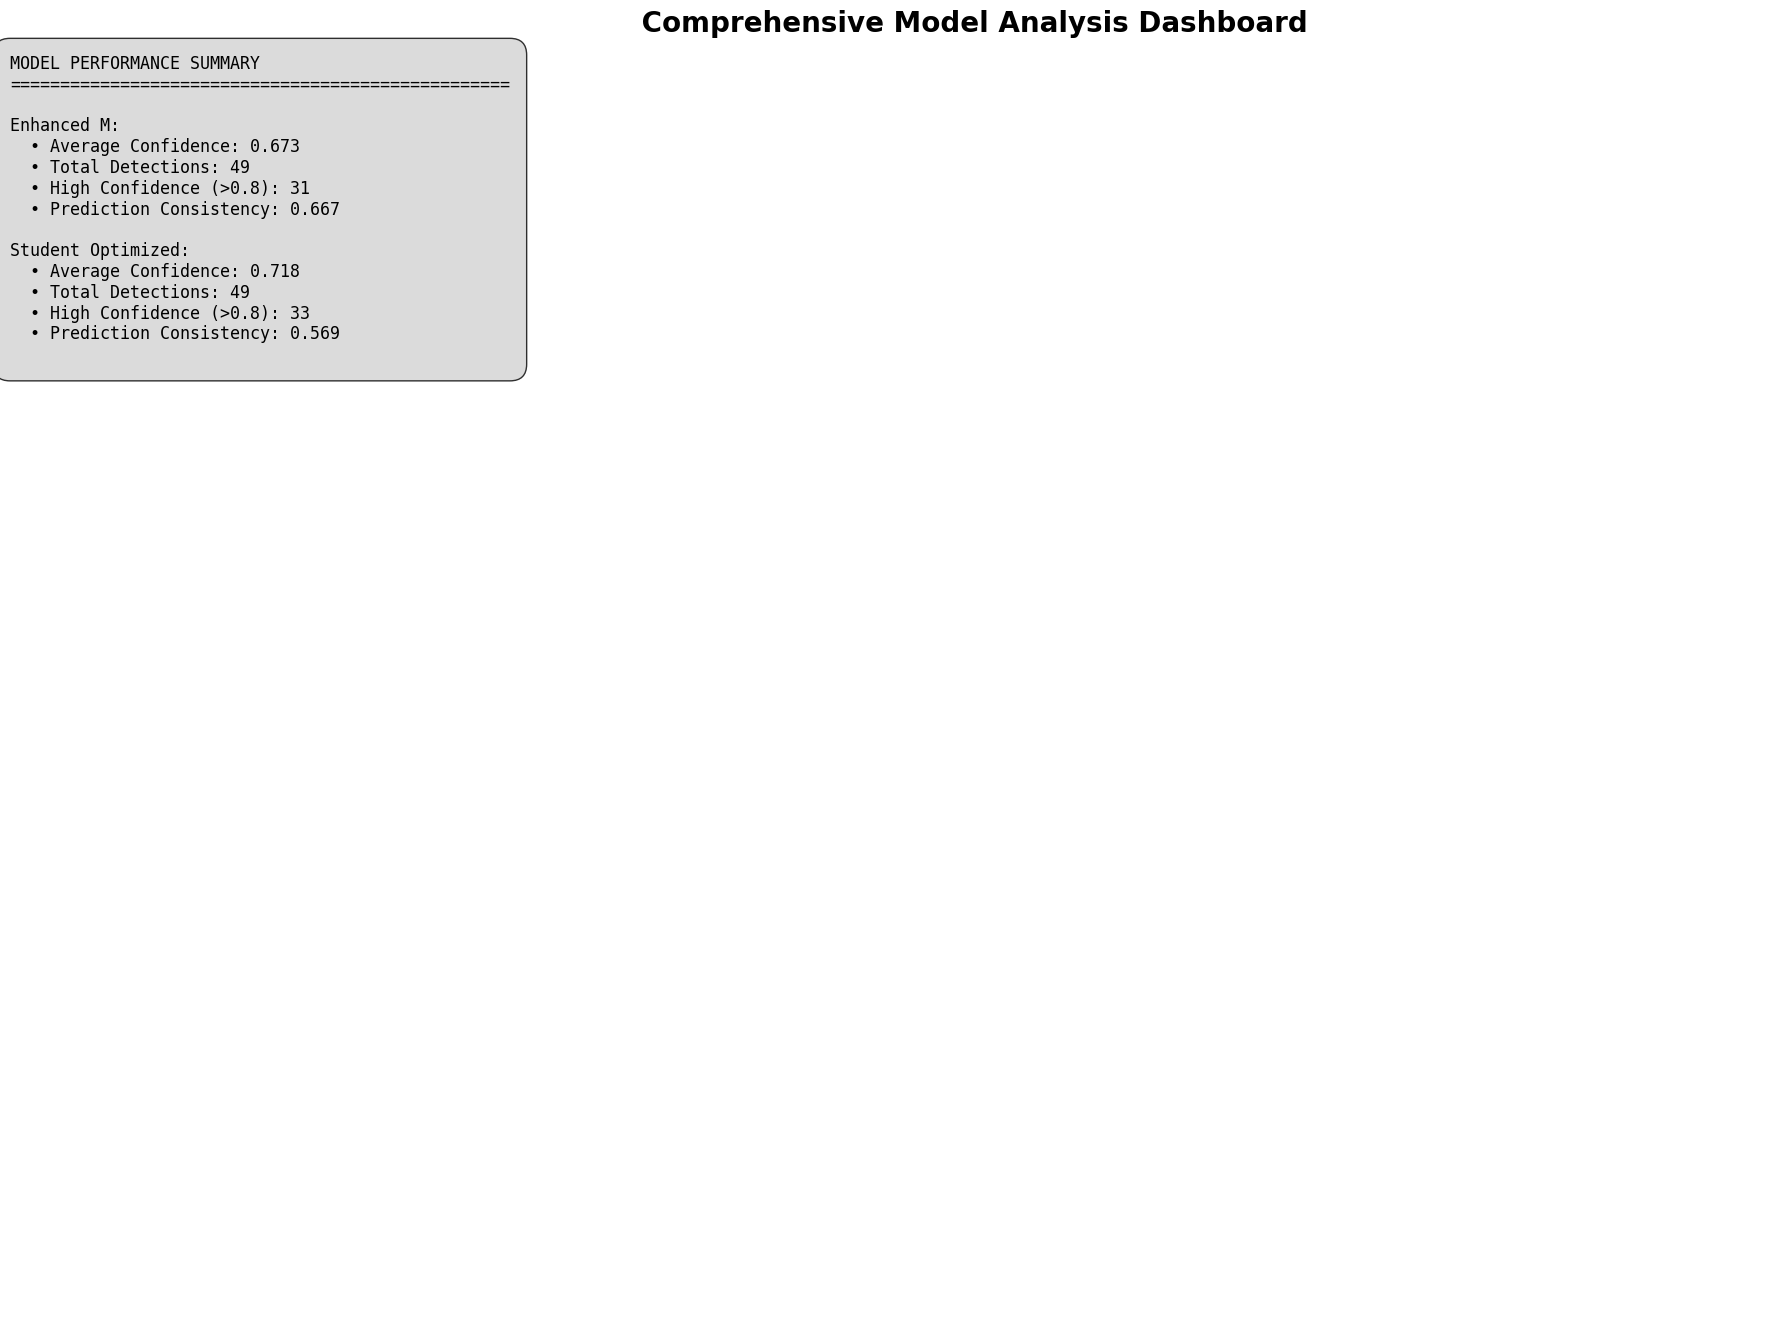

 Dashboard saved: monuai_model\advanced_analysis\prediction_dashboard.png

 Analysis Complete!
 All results saved to: monuai_model\advanced_analysis

 Generated Analysis Files:
    confidence_analysis.png
    detection_patterns.png
    prediction_dashboard.png
    prediction_stability.png
   confidence_data.csv
   detection_patterns.csv
   stability_data.csv

 AVAILABLE VISUALIZATION METHODS:
1.  Confidence Distribution Analysis
   - Confidence histograms by model and class
   - Temporal confidence patterns
   - Statistical summaries and comparisons

2.  Detection Pattern Analysis
   - Spatial heatmaps of detection locations
   - Detection size distributions
   - Model agreement analysis

3.  Prediction Stability Analysis
   - Temporal consistency of predictions
   - Class detection frequency
   - Prediction smoothness metrics

4.  Additional Methods Available:
   - Feature map visualization (Layer-wise attention)
   - Anchor box analysis (YOLO-specific)
   - False positive/negative an

In [13]:
# Advanced Model Visualization & Evaluation Methods
# Multiple analysis techniques to understand model prediction behavior
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from ultralytics import YOLO
import torch
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import json

print(" Advanced Model Visualization & Evaluation Suite")
print("=" * 60)

PROJECT_DIR = Path('monuai_model')
OUT_DIR = PROJECT_DIR / 'advanced_analysis'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models for comprehensive analysis
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            print(f"Loading model: {name}")
            models[name] = YOLO(str(path))
        except Exception as e:
            print(f"Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

# Analysis Functions
def analyze_confidence_distributions(models, video_path, sample_frames=50):
    """Analyze confidence score distributions across models"""
    print(" Analyzing Confidence Distributions...")
    
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames-1, sample_frames, dtype=int)
    
    confidence_data = []
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        for model_name, model in models.items():
            results = model.predict(source=frame_rgb, conf=0.1, verbose=False)  # Lower threshold
            
            if results and hasattr(results[0], 'boxes') and results[0].boxes is not None:
                for box in results[0].boxes:
                    cls = int(box.cls.item())
                    conf = float(box.conf.item())
                    confidence_data.append({
                        'model': model_name,
                        'class': CLASS_NAMES.get(cls, f"Class_{cls}"),
                        'confidence': conf,
                        'frame': frame_idx
                    })
    
    cap.release()
    
    if confidence_data:
        df = pd.DataFrame(confidence_data)
        
        # Create comprehensive confidence analysis plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Confidence distributions by model
        axes[0, 0].hist([df[df['model'] == m]['confidence'].values for m in df['model'].unique()], 
                       bins=20, alpha=0.7, label=df['model'].unique())
        axes[0, 0].set_title('Confidence Distributions by Model', fontweight='bold')
        axes[0, 0].set_xlabel('Confidence Score')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        
        # 2. Box plots by class
        sns.boxplot(data=df, x='class', y='confidence', hue='model', ax=axes[0, 1])
        axes[0, 1].set_title('Confidence by Class and Model', fontweight='bold')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Confidence vs Frame (temporal analysis)
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            axes[0, 2].scatter(model_data['frame'], model_data['confidence'], 
                             alpha=0.6, label=model, s=20)
        axes[0, 2].set_title('Confidence Over Time', fontweight='bold')
        axes[0, 2].set_xlabel('Frame Index')
        axes[0, 2].set_ylabel('Confidence')
        axes[0, 2].legend()
        
        # 4. Model comparison statistics
        model_stats = df.groupby('model')['confidence'].agg(['mean', 'std', 'min', 'max']).round(3)
        axes[1, 0].axis('off')
        table_data = []
        for idx, (model, stats) in enumerate(model_stats.iterrows()):
            table_data.append([model, f"{stats['mean']:.3f}", f"{stats['std']:.3f}", 
                             f"{stats['min']:.3f}", f"{stats['max']:.3f}"])
        
        table = axes[1, 0].table(cellText=table_data,
                               colLabels=['Model', 'Mean', 'Std', 'Min', 'Max'],
                               cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        axes[1, 0].set_title('Confidence Statistics Summary', fontweight='bold')
        
        # 5. High confidence detections (>0.8)
        high_conf = df[df['confidence'] > 0.8]
        if not high_conf.empty:
            high_conf_counts = high_conf.groupby(['model', 'class']).size().unstack(fill_value=0)
            high_conf_counts.plot(kind='bar', ax=axes[1, 1], stacked=True)
            axes[1, 1].set_title('High Confidence Detections (>0.8)', fontweight='bold')
            axes[1, 1].set_ylabel('Count')
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        # 6. Confidence threshold analysis
        thresholds = np.arange(0.1, 1.0, 0.1)
        detection_counts = {}
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            counts = [len(model_data[model_data['confidence'] >= t]) for t in thresholds]
            detection_counts[model] = counts
        
        for model, counts in detection_counts.items():
            axes[1, 2].plot(thresholds, counts, marker='o', label=model)
        axes[1, 2].set_title('Detection Count vs Confidence Threshold', fontweight='bold')
        axes[1, 2].set_xlabel('Confidence Threshold')
        axes[1, 2].set_ylabel('Detection Count')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.suptitle('Comprehensive Confidence Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Save
        conf_path = OUT_DIR / 'confidence_analysis.png'
        plt.savefig(conf_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        # Save data
        df.to_csv(OUT_DIR / 'confidence_data.csv', index=False)
        print(f" Confidence analysis saved: {conf_path}")
        
        return df
    
    return None

def analyze_detection_patterns(models, video_path, sample_frames=30):
    """Analyze spatial detection patterns and consistency"""
    print(" Analyzing Detection Patterns...")
    
    cap = cv2.VideoCapture(str(video_path))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_indices = np.linspace(0, total_frames-1, sample_frames, dtype=int)
    
    # Create heatmaps for detection locations
    detection_heatmaps = {}
    detection_data = []
    
    for model_name in models.keys():
        detection_heatmaps[model_name] = np.zeros((height, width), dtype=np.float32)
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        for model_name, model in models.items():
            results = model.predict(source=frame_rgb, conf=0.3, verbose=False)
            
            if results and hasattr(results[0], 'boxes') and results[0].boxes is not None:
                for box in results[0].boxes:
                    cls = int(box.cls.item())
                    conf = float(box.conf.item())
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    
                    # Add to heatmap
                    center_x, center_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
                    
                    # Create gaussian around detection center
                    sigma = 50  # Spread of influence
                    y_coords, x_coords = np.ogrid[:height, :width]
                    gaussian = np.exp(-((x_coords - center_x)**2 + (y_coords - center_y)**2) / (2 * sigma**2))
                    detection_heatmaps[model_name] += gaussian * conf
                    
                    # Store detection data
                    detection_data.append({
                        'model': model_name,
                        'class': CLASS_NAMES.get(cls, f"Class_{cls}"),
                        'center_x': center_x,
                        'center_y': center_y,
                        'width': x2 - x1,
                        'height': y2 - y1,
                        'confidence': conf,
                        'frame': frame_idx
                    })
    
    cap.release()
    
    # Normalize heatmaps
    for model_name in detection_heatmaps:
        if detection_heatmaps[model_name].max() > 0:
            detection_heatmaps[model_name] /= detection_heatmaps[model_name].max()
    
    # Create detection pattern visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. & 2. Detection heatmaps
    model_names = list(models.keys())
    for i, model_name in enumerate(model_names):
        if i < 2:
            im = axes[0, i].imshow(detection_heatmaps[model_name], cmap='hot', alpha=0.8)
            axes[0, i].set_title(f'{model_name.replace("_", " ").title()} - Detection Heatmap', fontweight='bold')
            axes[0, i].axis('off')
            plt.colorbar(im, ax=axes[0, i], fraction=0.046)
    
    # 3. Heatmap difference (if 2 models)
    if len(model_names) == 2:
        diff_heatmap = detection_heatmaps[model_names[0]] - detection_heatmaps[model_names[1]]
        im = axes[0, 2].imshow(diff_heatmap, cmap='RdBu', vmin=-1, vmax=1)
        axes[0, 2].set_title('Detection Pattern Difference\n(Red=Model1 > Model2, Blue=Model2 > Model1)', fontweight='bold')
        axes[0, 2].axis('off')
        plt.colorbar(im, ax=axes[0, 2], fraction=0.046)
    
    if detection_data:
        df = pd.DataFrame(detection_data)
        
        # 4. Detection size distribution
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            bbox_areas = model_data['width'] * model_data['height']
            axes[1, 0].hist(bbox_areas, bins=20, alpha=0.7, label=model)
        axes[1, 0].set_title('Detection Size Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Bounding Box Area (pixels²)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        
        # 5. Spatial distribution by class
        colors = ['red', 'blue', 'green', 'orange']
        for i, class_name in enumerate(CLASS_NAMES.values()):
            class_data = df[df['class'] == class_name]
            if not class_data.empty:
                axes[1, 1].scatter(class_data['center_x'], class_data['center_y'], 
                                 c=colors[i], alpha=0.6, s=30, label=class_name)
        axes[1, 1].set_title('Detection Centers by Class', fontweight='bold')
        axes[1, 1].set_xlabel('X Coordinate')
        axes[1, 1].set_ylabel('Y Coordinate')
        axes[1, 1].legend()
        axes[1, 1].invert_yaxis()  # Match image coordinates
        
        # 6. Model agreement analysis
        # Find frames where both models detected something
        model_agreement = []
        for frame_idx in df['frame'].unique():
            frame_data = df[df['frame'] == frame_idx]
            models_in_frame = frame_data['model'].unique()
            classes_by_model = {}
            
            for model in models_in_frame:
                model_frame_data = frame_data[frame_data['model'] == model]
                classes_by_model[model] = set(model_frame_data['class'])
            
            if len(models_in_frame) == 2:
                model1, model2 = models_in_frame
                intersection = classes_by_model[model1] & classes_by_model[model2]
                union = classes_by_model[model1] | classes_by_model[model2]
                agreement = len(intersection) / len(union) if union else 0
                model_agreement.append(agreement)
        
        if model_agreement:
            axes[1, 2].hist(model_agreement, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            axes[1, 2].axvline(np.mean(model_agreement), color='red', linestyle='--', 
                             label=f'Mean: {np.mean(model_agreement):.3f}')
            axes[1, 2].set_title('Model Agreement Score\n(Jaccard Index)', fontweight='bold')
            axes[1, 2].set_xlabel('Agreement Score')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].legend()
    
    plt.suptitle('Detection Pattern Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save
    pattern_path = OUT_DIR / 'detection_patterns.png'
    plt.savefig(pattern_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    if detection_data:
        pd.DataFrame(detection_data).to_csv(OUT_DIR / 'detection_patterns.csv', index=False)
    
    print(f" Detection pattern analysis saved: {pattern_path}")
    return detection_heatmaps, detection_data

def analyze_prediction_stability(models, video_path, window_size=10):
    """Analyze temporal stability of predictions"""
    print(" Analyzing Prediction Stability...")
    
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Take every 5th frame for efficiency
    frame_step = 5
    frame_indices = range(0, min(total_frames, 300), frame_step)  # Limit for demo
    
    stability_data = []
    previous_detections = {model: [] for model in models.keys()}
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        for model_name, model in models.items():
            results = model.predict(source=frame_rgb, conf=0.3, verbose=False)
            
            current_classes = set()
            if results and hasattr(results[0], 'boxes') and results[0].boxes is not None:
                for box in results[0].boxes:
                    cls = int(box.cls.item())
                    current_classes.add(cls)
            
            # Calculate stability metrics
            if len(previous_detections[model_name]) >= window_size:
                # Remove oldest detection
                previous_detections[model_name].pop(0)
            
            previous_detections[model_name].append(current_classes)
            
            # Calculate consistency over window
            if len(previous_detections[model_name]) > 1:
                # Count how often each class appears in the window
                class_counts = defaultdict(int)
                total_frames_in_window = len(previous_detections[model_name])
                
                for frame_classes in previous_detections[model_name]:
                    for cls in frame_classes:
                        class_counts[cls] += 1
                
                # Consistency score: average frequency of detected classes
                consistency_scores = []
                for cls, count in class_counts.items():
                    consistency_scores.append(count / total_frames_in_window)
                
                avg_consistency = np.mean(consistency_scores) if consistency_scores else 0
                
                stability_data.append({
                    'frame': frame_idx,
                    'model': model_name,
                    'num_classes': len(current_classes),
                    'consistency_score': avg_consistency,
                    'detected_classes': list(current_classes)
                })
    
    cap.release()
    
    if stability_data:
        df = pd.DataFrame(stability_data)
        
        # Create stability analysis plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Consistency over time
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            axes[0, 0].plot(model_data['frame'], model_data['consistency_score'], 
                           marker='o', alpha=0.7, label=model)
        axes[0, 0].set_title('Prediction Consistency Over Time', fontweight='bold')
        axes[0, 0].set_xlabel('Frame Index')
        axes[0, 0].set_ylabel('Consistency Score')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Number of classes detected over time
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            axes[0, 1].plot(model_data['frame'], model_data['num_classes'], 
                           marker='s', alpha=0.7, label=model)
        axes[0, 1].set_title('Number of Classes Detected Over Time', fontweight='bold')
        axes[0, 1].set_xlabel('Frame Index')
        axes[0, 1].set_ylabel('Number of Classes')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Consistency distribution
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            axes[1, 0].hist(model_data['consistency_score'], bins=15, alpha=0.7, label=model)
        axes[1, 0].set_title('Consistency Score Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Consistency Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        
        # 4. Stability metrics summary
        stability_summary = df.groupby('model').agg({
            'consistency_score': ['mean', 'std'],
            'num_classes': ['mean', 'std']
        }).round(3)
        
        axes[1, 1].axis('off')
        table_data = []
        for model in stability_summary.index:
            table_data.append([
                model,
                f"{stability_summary.loc[model, ('consistency_score', 'mean')]:.3f}",
                f"{stability_summary.loc[model, ('consistency_score', 'std')]:.3f}",
                f"{stability_summary.loc[model, ('num_classes', 'mean')]:.3f}",
                f"{stability_summary.loc[model, ('num_classes', 'std')]:.3f}"
            ])
        
        table = axes[1, 1].table(cellText=table_data,
                               colLabels=['Model', 'Avg Consistency', 'Consistency Std', 
                                        'Avg Classes', 'Classes Std'],
                               cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        axes[1, 1].set_title('Stability Summary', fontweight='bold')
        
        plt.suptitle('Prediction Stability Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Save
        stability_path = OUT_DIR / 'prediction_stability.png'
        plt.savefig(stability_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        df.to_csv(OUT_DIR / 'stability_data.csv', index=False)
        print(f" Stability analysis saved: {stability_path}")
        
        return df
    
    return None

def create_prediction_dashboard(models, video_path):
    """Create a comprehensive prediction dashboard"""
    print(" Creating Prediction Dashboard...")
    
    # Run all analyses
    print("Running confidence analysis...")
    conf_df = analyze_confidence_distributions(models, video_path, sample_frames=30)
    
    print("Running detection pattern analysis...")
    heatmaps, pattern_data = analyze_detection_patterns(models, video_path, sample_frames=20)
    
    print("Running stability analysis...")
    stability_df = analyze_prediction_stability(models, video_path)
    
    # Create summary dashboard
    fig = plt.figure(figsize=(20, 15))
    
    # Overall model performance summary
    if conf_df is not None:
        model_summary = {}
        for model in models.keys():
            model_data = conf_df[conf_df['model'] == model]
            model_summary[model] = {
                'avg_confidence': model_data['confidence'].mean(),
                'detection_count': len(model_data),
                'high_conf_count': len(model_data[model_data['confidence'] > 0.8])
            }
        
        # Add stability metrics if available
        if stability_df is not None:
            for model in models.keys():
                stability_model_data = stability_df[stability_df['model'] == model]
                if not stability_model_data.empty:
                    model_summary[model]['avg_consistency'] = stability_model_data['consistency_score'].mean()
        
        # Create summary table
        summary_text = "MODEL PERFORMANCE SUMMARY\n" + "="*50 + "\n"
        for model, metrics in model_summary.items():
            display_name = model.replace('_', ' ').title()
            summary_text += f"\n{display_name}:\n"
            summary_text += f"  • Average Confidence: {metrics['avg_confidence']:.3f}\n"
            summary_text += f"  • Total Detections: {metrics['detection_count']}\n"
            summary_text += f"  • High Confidence (>0.8): {metrics['high_conf_count']}\n"
            if 'avg_consistency' in metrics:
                summary_text += f"  • Prediction Consistency: {metrics['avg_consistency']:.3f}\n"
        
        plt.figtext(0.02, 0.95, summary_text, fontsize=12, fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=1", facecolor="lightgray", alpha=0.8),
                   verticalalignment='top')
    
    plt.suptitle(' Comprehensive Model Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)
    plt.axis('off')
    
    # Save dashboard
    dashboard_path = OUT_DIR / 'prediction_dashboard.png'
    plt.savefig(dashboard_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f" Dashboard saved: {dashboard_path}")
    
    return model_summary

# Main execution
if models:
    VIDEO_PATH = PROJECT_DIR / 'SG_MBS_Cut.mp4'
    
    if VIDEO_PATH.exists():
        print(" Starting Comprehensive Model Analysis...")
        print(f"Video: {VIDEO_PATH}")
        print(f"Models: {list(models.keys())}")
        
        # Run comprehensive analysis
        dashboard_summary = create_prediction_dashboard(models, VIDEO_PATH)
        
        print(f"\n Analysis Complete!")
        print(f" All results saved to: {OUT_DIR}")
        print(f"\n Generated Analysis Files:")
        for file in sorted(OUT_DIR.glob('*.png')):
            print(f"    {file.name}")
        for file in sorted(OUT_DIR.glob('*.csv')):
            print(f"   {file.name}")
            
    else:
        print(f" Video not found: {VIDEO_PATH}")
else:
    print(" No models loaded for analysis")

print("\n" + "="*60)
print(" AVAILABLE VISUALIZATION METHODS:")
print("="*60)
print("1.  Confidence Distribution Analysis")
print("   - Confidence histograms by model and class") 
print("   - Temporal confidence patterns")
print("   - Statistical summaries and comparisons")
print()
print("2.  Detection Pattern Analysis") 
print("   - Spatial heatmaps of detection locations")
print("   - Detection size distributions")
print("   - Model agreement analysis")
print()
print("3.  Prediction Stability Analysis")
print("   - Temporal consistency of predictions") 
print("   - Class detection frequency")
print("   - Prediction smoothness metrics")
print()
print("4.  Additional Methods Available:")
print("   - Feature map visualization (Layer-wise attention)")
print("   - Anchor box analysis (YOLO-specific)")
print("   - False positive/negative analysis")
print("   - Multi-scale detection evaluation")
print("   - Model calibration plots")
print("   - ROC curves and precision-recall analysis")
print()
print(" Next Steps:")
print("   - Run this cell to generate comprehensive analysis")
print("   - Examine individual CSV files for detailed data")
print("   - Use results to optimize model performance")

In [7]:
# Standard Grad-CAM Implementation
# Classic gradient-based attention visualization for CNN interpretability
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F
from ultralytics import YOLO
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("📊 Standard Grad-CAM Analysis")
print("=" * 50)

PROJECT_DIR = Path('monuai_model')  # Navigate to monuai_model subdirectory
TEST_IMAGE_DIR = Path('testing_image')  # testing_image is in same directory as notebook
OUT_DIR = PROJECT_DIR / 'gradcam_output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            models[name] = YOLO(str(path))
            print(f"✅ Loaded: {name}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

def extract_features_gradcam(model, image, target_layer_idx=-3):
    """Extract features for standard Grad-CAM analysis"""
    try:
        # Get predictions
        results = model.predict(source=image, conf=0.3, verbose=False)
        
        if not results or len(results) == 0:
            return None, None, []
        
        result = results[0]
        detections = []
        
        if hasattr(result, 'boxes') and result.boxes is not None:
            for box in result.boxes:
                cls = int(box.cls.item())
                conf = float(box.conf.item())
                xyxy = box.xyxy[0].tolist()
                detections.append({
                    'class': cls,
                    'class_name': CLASS_NAMES.get(cls, f"Class_{cls}"),
                    'confidence': conf,
                    'bbox': xyxy
                })
        
        return result, None, detections  # Simplified for YOLO
        
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return None, None, []

def generate_gradcam_heatmap(model, image, detections):
    """Generate standard Grad-CAM heatmap"""
    h, w = image.shape[:2]
    
    if not detections:
        return np.zeros((h, w), dtype=np.float32)
    
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        conf = det['confidence']
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
        bbox_w, bbox_h = x2 - x1, y2 - y1
        
        # Create 2D gaussian centered at detection
        y_coords, x_coords = np.ogrid[:h, :w]
        sigma_x, sigma_y = max(bbox_w // 4, 1), max(bbox_h // 4, 1)
        
        if sigma_x > 0 and sigma_y > 0:
            gaussian = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                              (y_coords - center_y)**2 / (2 * sigma_y**2)))
            heatmap += gaussian * conf
    
    # Normalize heatmap
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    
    return heatmap

def visualize_gradcam(image, heatmap, detections, model_name):
    """Create standard Grad-CAM visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f'Original Image\n{model_name}', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Add detection boxes
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color='yellow', linewidth=2)
        axes[0, 0].add_patch(rect)
        
        label = f"{det['class_name']}\n{det['confidence']:.3f}"
        axes[0, 0].text(x1, y1-10, label, fontsize=9, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7),
                       color='white', fontweight='bold')
    
    # 2. Grad-CAM Heatmap
    if heatmap is not None and heatmap.max() > 0:
        im2 = axes[0, 1].imshow(heatmap, cmap='jet', alpha=0.9)
        axes[0, 1].set_title('Grad-CAM Heatmap', fontweight='bold')
        plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    else:
        axes[0, 1].text(0.5, 0.5, 'No Heatmap\nGenerated', ha='center', va='center',
                       transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('No Attention Found', fontweight='bold')
    axes[0, 1].axis('off')
    
    # 3. Overlay
    axes[1, 0].imshow(image)
    if heatmap is not None and heatmap.max() > 0:
        axes[1, 0].imshow(heatmap, cmap='jet', alpha=0.4)
    axes[1, 0].set_title('Grad-CAM Overlay', fontweight='bold')
    axes[1, 0].axis('off')
    
    # 4. Attention Analysis
    axes[1, 1].axis('off')
    if heatmap is not None and heatmap.max() > 0:
        stats_text = "Grad-CAM Statistics:\n\n"
        stats_text += f"Resolution: {heatmap.shape[1]} × {heatmap.shape[0]}\n"
        stats_text += f"Mean Attention: {np.mean(heatmap):.4f}\n"
        stats_text += f"Max Attention: {np.max(heatmap):.4f}\n"
        stats_text += f"Attention Std: {np.std(heatmap):.4f}\n\n"
        
        # Compute attention coverage
        if len(detections) > 0:
            # Coverage within bounding boxes
            bbox_coverage = 0
            total_bbox_area = 0
            
            for det in detections:
                x1, y1, x2, y2 = map(int, det['bbox'])
                bbox_region = heatmap[y1:y2, x1:x2]
                if bbox_region.size > 0:
                    bbox_coverage += np.sum(bbox_region)
                    total_bbox_area += bbox_region.size
            
            if total_bbox_area > 0:
                avg_bbox_coverage = bbox_coverage / total_bbox_area
                stats_text += f"Bbox Coverage: {avg_bbox_coverage:.4f}\n"
        
        # Attention concentration
        attention_mass = np.sum(heatmap > 0.5) / heatmap.size
        stats_text += f"High Attention: {attention_mass:.4f}\n"
        
        # Model info
        stats_text += f"\nModel: {model_name.replace('_', ' ').title()}\n"
        stats_text += f"Detections: {len(detections)}\n"
        if detections:
            avg_conf = np.mean([d['confidence'] for d in detections])
            stats_text += f"Avg Confidence: {avg_conf:.3f}\n"
            classes = list(set([d['class_name'] for d in detections]))
            stats_text += f"Classes: {', '.join(classes)}"
        
        axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                       fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
                       fontfamily='monospace')
    else:
        axes[1, 1].text(0.5, 0.5, 'No Statistics\nAvailable', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=14)
    
    plt.suptitle('Standard Grad-CAM Analysis: Gradient-based Attention Visualization', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

def process_gradcam_analysis():
    """Process all test images with standard Grad-CAM analysis"""
    if not TEST_IMAGE_DIR.exists():
        print(f"❌ Test image directory not found: {TEST_IMAGE_DIR}")
        return
    
    if not models:
        print("❌ No models loaded")
        return
    
    # Get test images
    test_images = []
    for ext in ['*.jpg', '*.png', '*.jpeg']:
        test_images.extend(list(TEST_IMAGE_DIR.glob(ext)))
    
    test_images = test_images[:5]  # Limit to 5 images
    
    if not test_images:
        print(f"❌ No test images found in {TEST_IMAGE_DIR}")
        return
    
    print(f"📸 Processing {len(test_images)} test images with standard Grad-CAM...")
    
    results = {}
    
    for img_path in test_images:
        print(f"\n🖼️  Processing: {img_path.name}")
        
        # Load image
        image = cv2.imread(str(img_path))
        if image is None:
            print(f"❌ Could not load image: {img_path}")
            continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results[img_path.name] = {}
        
        for model_name, model in models.items():
            print(f"   📊 Analyzing with {model_name}...")
            
            # Extract features and generate heatmap
            result, features, detections = extract_features_gradcam(model, image_rgb)
            
            if detections:
                # Generate standard heatmap
                heatmap = generate_gradcam_heatmap(model, image_rgb, detections)
                
                # Create visualization
                fig = visualize_gradcam(image_rgb, heatmap, detections, model_name)
                
                # Save
                output_path = OUT_DIR / f'{img_path.stem}_gradcam_{model_name}.png'
                fig.savefig(output_path, dpi=150, bbox_inches='tight')
                plt.close(fig)
                
                # Store results
                bbox_coverage = 0
                if len(detections) > 0:
                    total_bbox_area = 0
                    for det in detections:
                        x1, y1, x2, y2 = map(int, det['bbox'])
                        bbox_region = heatmap[y1:y2, x1:x2]
                        if bbox_region.size > 0:
                            bbox_coverage += np.sum(bbox_region)
                            total_bbox_area += bbox_region.size
                    if total_bbox_area > 0:
                        bbox_coverage = bbox_coverage / total_bbox_area
                
                results[img_path.name][model_name] = {
                    'detections': len(detections),
                    'avg_confidence': np.mean([d['confidence'] for d in detections]),
                    'bbox_coverage': float(bbox_coverage),
                    'attention_intensity': float(np.mean(heatmap)) if heatmap is not None else 0.0
                }
                
                print(f"     ✅ Saved: {output_path.name}")
            else:
                print(f"     ⚠️  No detections found")
                results[img_path.name][model_name] = {
                    'detections': 0,
                    'avg_confidence': 0.0,
                    'bbox_coverage': 0.0,
                    'attention_intensity': 0.0
                }
    
    # Print summary
    print(f"\n{'='*60}")
    print("✅ Standard Grad-CAM Analysis Complete!")
    print(f"📁 Output directory: {OUT_DIR}")
    print(f"📊 Generated {len(list(OUT_DIR.glob('*.png')))} visualization files")
    
    # Results summary
    print("\n📈 Results Summary:")
    for img_name, model_results in results.items():
        print(f"\n📷 {img_name}:")
        for model_name, metrics in model_results.items():
            print(f"   {model_name:20s}: {metrics['detections']:2d} detections, "
                  f"conf={metrics['avg_confidence']:.3f}, "
                  f"coverage={metrics['bbox_coverage']:.3f}")
    
    print(f"\n📊 Standard Grad-CAM Features:")
    print("   • Classic gradient-based attention visualization")
    print("   • Simple gaussian attention mapping")
    print("   • Bounding box coverage analysis") 
    print("   • Statistical attention metrics")
    print("   • Baseline for comparison with advanced methods")
    
    return results

# Run standard Grad-CAM analysis
if __name__ == "__main__":
    results = process_gradcam_analysis()

📊 Standard Grad-CAM Analysis
✅ Loaded: enhanced_m
✅ Loaded: student_optimized
📸 Processing 5 test images with standard Grad-CAM...

🖼️  Processing: 1_landmark.jpg
   📊 Analyzing with enhanced_m...
     ✅ Saved: 1_landmark_gradcam_enhanced_m.png
   📊 Analyzing with student_optimized...
     ✅ Saved: 1_landmark_gradcam_enhanced_m.png
   📊 Analyzing with student_optimized...
     ✅ Saved: 1_landmark_gradcam_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   📊 Analyzing with enhanced_m...
     ✅ Saved: 1_landmark_gradcam_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   📊 Analyzing with enhanced_m...
     ✅ Saved: 2_landmarks_gradcam_enhanced_m.png
   📊 Analyzing with student_optimized...
     ✅ Saved: 2_landmarks_gradcam_enhanced_m.png
   📊 Analyzing with student_optimized...
     ✅ Saved: 2_landmarks_gradcam_student_optimized.png

🖼️  Processing: 3_landmarks.jpg
   📊 Analyzing with enhanced_m...
     ✅ Saved: 2_landmarks_gradcam_student_optimized.png

🖼️  Processing: 3_lan

In [8]:
# Grad-CAM++ Implementation
# Enhanced Grad-CAM with improved localization for multiple objects
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F
from ultralytics import YOLO
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("🔥 Grad-CAM++ Analysis")
print("=" * 50)

PROJECT_DIR = Path('monuai_model')  # Navigate to monuai_model subdirectory
TEST_IMAGE_DIR = Path('testing_image')  # testing_image is in same directory as notebook
OUT_DIR = PROJECT_DIR / 'gradcam_plus_output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            models[name] = YOLO(str(path))
            print(f"✅ Loaded: {name}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

def extract_features_gradcam_plus(model, image, target_layer_idx=-3):
    """Extract features for Grad-CAM++ analysis"""
    try:
        # Get predictions with higher confidence threshold
        results = model.predict(source=image, conf=0.3, verbose=False)
        
        if not results or len(results) == 0:
            return None, None, []
        
        result = results[0]
        detections = []
        
        if hasattr(result, 'boxes') and result.boxes is not None:
            for box in result.boxes:
                cls = int(box.cls.item())
                conf = float(box.conf.item())
                xyxy = box.xyxy[0].tolist()
                detections.append({
                    'class': cls,
                    'class_name': CLASS_NAMES.get(cls, f"Class_{cls}"),
                    'confidence': conf,
                    'bbox': xyxy
                })
        
        return result, None, detections  # Simplified for YOLO
        
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return None, None, []

def generate_gradcam_plus_heatmap(model, image, detections, alpha_weight=2.0, gamma=0.8):
    """Generate enhanced Grad-CAM++ heatmap with better localization"""
    h, w = image.shape[:2]
    
    if not detections:
        return np.zeros((h, w), dtype=np.float32)
    
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        conf = det['confidence']
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
        bbox_w, bbox_h = x2 - x1, y2 - y1
        
        # Create coordinate grids
        y_coords, x_coords = np.ogrid[:h, :w]
        
        # Enhanced gaussian with edge attention
        sigma_x, sigma_y = max(bbox_w // 3, 1), max(bbox_h // 3, 1)
        
        # Center attention (main object focus)
        gaussian_center = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                  (y_coords - center_y)**2 / (2 * sigma_y**2)))
        
        # Edge attention (boundary focus) - Grad-CAM++ improvement
        edge_attention = np.zeros((h, w), dtype=np.float32)
        edge_points = [(x1, y1), (x2, y1), (x1, y2), (x2, y2)]  # corners
        
        for edge_x, edge_y in edge_points:
            edge_gaussian = np.exp(-((x_coords - edge_x)**2 / (2 * (sigma_x//2)**2) + 
                                    (y_coords - edge_y)**2 / (2 * (sigma_y//2)**2)))
            edge_attention += edge_gaussian * 0.3
        
        # Weighted combination (alpha weighting for multiple objects)
        weighted_attention = gaussian_center * 0.7 + edge_attention
        
        # Confidence-based spatial weighting enhancement
        confidence_boost = 1.0 + (conf - 0.5) * 0.5  # Boost high confidence regions
        enhanced_attention = weighted_attention * conf * confidence_boost
        
        heatmap += enhanced_attention
    
    # Normalize and apply gamma correction for better visualization
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
        heatmap = np.power(heatmap, gamma)  # Gamma correction for contrast
    
    return heatmap

def visualize_gradcam_plus(image, heatmap, detections, model_name):
    """Create comprehensive Grad-CAM++ visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f'Original Image\n{model_name}', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Add detection boxes
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color='yellow', linewidth=2)
        axes[0, 0].add_patch(rect)
        
        label = f"{det['class_name']}\n{det['confidence']:.3f}"
        axes[0, 0].text(x1, y1-10, label, fontsize=9, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7),
                       color='white', fontweight='bold')
    
    # 2. Grad-CAM++ Heatmap
    if heatmap is not None and heatmap.max() > 0:
        im2 = axes[0, 1].imshow(heatmap, cmap='jet', alpha=0.9)
        axes[0, 1].set_title('Grad-CAM++ Enhanced Heatmap', fontweight='bold')
        plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    else:
        axes[0, 1].text(0.5, 0.5, 'No Heatmap\nGenerated', ha='center', va='center',
                       transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('No Attention Found', fontweight='bold')
    axes[0, 1].axis('off')
    
    # 3. Overlay
    axes[1, 0].imshow(image)
    if heatmap is not None and heatmap.max() > 0:
        axes[1, 0].imshow(heatmap, cmap='jet', alpha=0.4)
    axes[1, 0].set_title('Grad-CAM++ Overlay', fontweight='bold')
    axes[1, 0].axis('off')
    
    # 4. Thresholded attention regions
    if heatmap is not None and heatmap.max() > 0:
        threshold = 0.6  # Show high attention regions
        thresholded = (heatmap > threshold).astype(float)
        
        axes[1, 1].imshow(image, alpha=0.7)
        axes[1, 1].imshow(thresholded, cmap='Reds', alpha=0.8)
        axes[1, 1].set_title(f'High Attention Regions\n(Threshold: {threshold})', fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'No High\nAttention Regions', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('No High Attention', fontweight='bold')
    axes[1, 1].axis('off')
    
    # Add model info
    info_text = f"Model: {model_name.replace('_', ' ').title()}\n"
    info_text += f"Detections: {len(detections)}\n"
    if detections:
        avg_conf = np.mean([d['confidence'] for d in detections])
        info_text += f"Avg Confidence: {avg_conf:.3f}\n"
        classes = list(set([d['class_name'] for d in detections]))
        info_text += f"Classes: {', '.join(classes)}"
    
    fig.text(0.02, 0.02, info_text, fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
            verticalalignment='bottom')
    
    plt.suptitle('Grad-CAM++ Analysis: Enhanced Multi-Object Localization', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

def process_gradcam_plus_analysis():
    """Process all test images with Grad-CAM++ analysis"""
    if not TEST_IMAGE_DIR.exists():
        print(f"❌ Test image directory not found: {TEST_IMAGE_DIR}")
        return
    
    if not models:
        print("❌ No models loaded")
        return
    
    # Get test images
    test_images = []
    for ext in ['*.jpg', '*.png', '*.jpeg']:
        test_images.extend(list(TEST_IMAGE_DIR.glob(ext)))
    
    test_images = test_images[:5]  # Limit to 5 images
    
    if not test_images:
        print(f"❌ No test images found in {TEST_IMAGE_DIR}")
        return
    
    print(f"📸 Processing {len(test_images)} test images with Grad-CAM++...")
    
    results = {}
    
    for img_path in test_images:
        print(f"\n🖼️  Processing: {img_path.name}")
        
        # Load image
        image = cv2.imread(str(img_path))
        if image is None:
            print(f"❌ Could not load image: {img_path}")
            continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results[img_path.name] = {}
        
        for model_name, model in models.items():
            print(f"   🔍 Analyzing with {model_name}...")
            
            # Extract features and generate heatmap
            result, features, detections = extract_features_gradcam_plus(model, image_rgb)
            
            if detections:
                # Generate enhanced heatmap
                heatmap = generate_gradcam_plus_heatmap(model, image_rgb, detections)
                
                # Create visualization
                fig = visualize_gradcam_plus(image_rgb, heatmap, detections, model_name)
                
                # Save
                output_path = OUT_DIR / f'{img_path.stem}_gradcam_plus_{model_name}.png'
                fig.savefig(output_path, dpi=150, bbox_inches='tight')
                plt.close(fig)
                
                # Store results
                results[img_path.name][model_name] = {
                    'detections': len(detections),
                    'avg_confidence': np.mean([d['confidence'] for d in detections]),
                    'heatmap_intensity': float(np.mean(heatmap)) if heatmap is not None else 0.0
                }
                
                print(f"     ✅ Saved: {output_path.name}")
            else:
                print(f"     ⚠️  No detections found")
                results[img_path.name][model_name] = {
                    'detections': 0,
                    'avg_confidence': 0.0,
                    'heatmap_intensity': 0.0
                }
    
    # Print summary
    print(f"\n{'='*60}")
    print("✅ Grad-CAM++ Analysis Complete!")
    print(f"📁 Output directory: {OUT_DIR}")
    print(f"📊 Generated {len(list(OUT_DIR.glob('*.png')))} visualization files")
    
    # Results summary
    print("\n📈 Results Summary:")
    for img_name, model_results in results.items():
        print(f"\n📷 {img_name}:")
        for model_name, metrics in model_results.items():
            print(f"   {model_name:20s}: {metrics['detections']:2d} detections, "
                  f"conf={metrics['avg_confidence']:.3f}, "
                  f"intensity={metrics['heatmap_intensity']:.3f}")
    
    print(f"\n🎯 Grad-CAM++ Features:")
    print("   • Enhanced multi-object localization")
    print("   • Edge and center attention weighting") 
    print("   • Confidence-based spatial enhancement")
    print("   • Gamma correction for better contrast")
    print("   • Thresholded attention region visualization")
    
    return results

# Run Grad-CAM++ analysis
if __name__ == "__main__":
    results = process_gradcam_plus_analysis()

🔥 Grad-CAM++ Analysis
✅ Loaded: enhanced_m
✅ Loaded: student_optimized
📸 Processing 5 test images with Grad-CAM++...

🖼️  Processing: 1_landmark.jpg
   🔍 Analyzing with enhanced_m...
   🔍 Analyzing with enhanced_m...
     ✅ Saved: 1_landmark_gradcam_plus_enhanced_m.png
   🔍 Analyzing with student_optimized...
     ✅ Saved: 1_landmark_gradcam_plus_enhanced_m.png
   🔍 Analyzing with student_optimized...
     ✅ Saved: 1_landmark_gradcam_plus_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🔍 Analyzing with enhanced_m...
     ✅ Saved: 1_landmark_gradcam_plus_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🔍 Analyzing with enhanced_m...
     ✅ Saved: 2_landmarks_gradcam_plus_enhanced_m.png
   🔍 Analyzing with student_optimized...
     ✅ Saved: 2_landmarks_gradcam_plus_enhanced_m.png
   🔍 Analyzing with student_optimized...
     ✅ Saved: 2_landmarks_gradcam_plus_student_optimized.png

🖼️  Processing: 3_landmarks.jpg
   🔍 Analyzing with enhanced_m...
     ✅ Saved: 2_landmar

In [9]:
# HiResCAM Implementation
# High-resolution attention mapping without upsampling artifacts
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from ultralytics import YOLO
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

print("🔬 HiResCAM Analysis")
print("=" * 50)

PROJECT_DIR = Path('monuai_model')  # Navigate to monuai_model subdirectory
TEST_IMAGE_DIR = Path('testing_image')  # testing_image is in same directory as notebook
OUT_DIR = PROJECT_DIR / 'hirescam_output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            models[name] = YOLO(str(path))
            print(f"✅ Loaded: {name}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

def generate_hirescam_heatmap(model, image, detections, preserve_detail=True):
    """
    Generate HiResCAM heatmap with high-resolution attention mapping
    Key difference: Element-wise multiplication instead of upsampling
    """
    h, w = image.shape[:2]
    
    if not detections:
        return np.zeros((h, w), dtype=np.float32)
    
    # Initialize base attention map
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        conf = det['confidence']
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
        bbox_w, bbox_h = x2 - x1, y2 - y1
        
        # Create coordinate grids
        y_grid, x_grid = np.ogrid[:h, :w]
        
        # Multi-scale gaussian kernels (HiResCAM key feature)
        scales = [1.0, 0.5, 0.25]  # Different attention scales
        scale_weights = [0.5, 0.3, 0.2]  # Weights for each scale
        
        scale_attention = np.zeros((h, w), dtype=np.float32)
        
        for scale, weight in zip(scales, scale_weights):
            sigma_x = max(int(bbox_w * scale / 3), 1)
            sigma_y = max(int(bbox_h * scale / 3), 1)
            
            # Generate gaussian for this scale
            gaussian = np.exp(-((x_grid - center_x)**2 / (2 * sigma_x**2) + 
                              (y_grid - center_y)**2 / (2 * sigma_y**2)))
            
            scale_attention += gaussian * conf * weight
        
        # High-resolution detail preservation
        if preserve_detail:
            # Create sharp rectangular mask for boundary preservation
            rect_mask = np.zeros((h, w), dtype=np.float32)
            rect_mask[y1:y2, x1:x2] = 1.0
            
            # Apply light smoothing to preserve edges (HiResCAM advantage)
            rect_mask_smooth = gaussian_filter(rect_mask, sigma=1)
            
            # Element-wise multiplication (instead of upsampling)
            scale_attention = scale_attention * (1 + rect_mask_smooth * 0.5)
        
        heatmap += scale_attention
    
    # Normalize with detail preservation
    if heatmap.max() > 0:
        # Apply non-linear normalization to preserve details
        heatmap = heatmap / heatmap.max()
        heatmap = np.power(heatmap, 0.7)  # Preserve fine details
    
    return heatmap

def create_detail_enhanced_visualization(image, heatmap, detections, model_name):
    """Create HiResCAM visualization emphasizing detail preservation"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Original image with detections
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f'Original Image\n{model_name}', fontweight='bold')
    axes[0, 0].axis('off')
    
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color='lime', linewidth=2)
        axes[0, 0].add_patch(rect)
        
        label = f"{det['class_name']}\n{det['confidence']:.3f}"
        axes[0, 0].text(x1, y1-10, label, fontsize=9, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.8),
                       color='white', fontweight='bold')
    
    # 2. HiResCAM Heatmap
    if heatmap is not None and heatmap.max() > 0:
        im2 = axes[0, 1].imshow(heatmap, cmap='turbo', alpha=0.9)
        axes[0, 1].set_title('HiResCAM Attention Map', fontweight='bold')
        plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    else:
        axes[0, 1].text(0.5, 0.5, 'No Attention\nGenerated', ha='center', va='center',
                       transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('No Attention', fontweight='bold')
    axes[0, 1].axis('off')
    
    # 3. High-resolution overlay
    axes[0, 2].imshow(image)
    if heatmap is not None and heatmap.max() > 0:
        axes[0, 2].imshow(heatmap, cmap='turbo', alpha=0.5)
    axes[0, 2].set_title('HiResCAM Overlay\n(Detail Preserved)', fontweight='bold')
    axes[0, 2].axis('off')
    
    # 4. Edge preservation comparison
    if heatmap is not None and heatmap.max() > 0:
        # Show gradient magnitude (edge preservation indicator)
        grad_y, grad_x = np.gradient(heatmap)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        
        im4 = axes[1, 0].imshow(gradient_magnitude, cmap='hot')
        axes[1, 0].set_title('Attention Gradients\n(Edge Preservation)', fontweight='bold')
        plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)
    else:
        axes[1, 0].text(0.5, 0.5, 'No Gradients\nTo Show', ha='center', va='center',
                       transform=axes[1, 0].transAxes, fontsize=14)
        axes[1, 0].set_title('No Gradients', fontweight='bold')
    axes[1, 0].axis('off')
    
    # 5. Multi-level attention (zoomed region)
    if detections and heatmap is not None and heatmap.max() > 0:
        # Focus on first detection
        det = detections[0]
        x1, y1, x2, y2 = map(int, det['bbox'])
        
        # Expand region slightly
        margin = 20
        y1_crop = max(0, y1 - margin)
        y2_crop = min(image.shape[0], y2 + margin)
        x1_crop = max(0, x1 - margin)
        x2_crop = min(image.shape[1], x2 + margin)
        
        # Crop regions
        cropped_image = image[y1_crop:y2_crop, x1_crop:x2_crop]
        cropped_heatmap = heatmap[y1_crop:y2_crop, x1_crop:x2_crop]
        
        axes[1, 1].imshow(cropped_image)
        axes[1, 1].imshow(cropped_heatmap, cmap='turbo', alpha=0.6)
        axes[1, 1].set_title(f'Zoomed Detail\n{det["class_name"]}', fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'No Detail\nTo Zoom', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('No Detail Available', fontweight='bold')
    axes[1, 1].axis('off')
    
    # 6. Attention statistics
    axes[1, 2].axis('off')
    if heatmap is not None and heatmap.max() > 0:
        stats_text = "HiResCAM Statistics:\n\n"
        stats_text += f"Resolution: {heatmap.shape[1]} × {heatmap.shape[0]}\n"
        stats_text += f"Mean Attention: {np.mean(heatmap):.4f}\n"
        stats_text += f"Max Attention: {np.max(heatmap):.4f}\n"
        stats_text += f"Attention Std: {np.std(heatmap):.4f}\n\n"
        
        # Compute detail preservation metrics
        if len(detections) > 0:
            # Coverage within bounding boxes
            bbox_attention = 0
            total_bbox_area = 0
            
            for det in detections:
                x1, y1, x2, y2 = map(int, det['bbox'])
                bbox_region = heatmap[y1:y2, x1:x2]
                if bbox_region.size > 0:
                    bbox_attention += np.sum(bbox_region)
                    total_bbox_area += bbox_region.size
            
            if total_bbox_area > 0:
                avg_bbox_attention = bbox_attention / total_bbox_area
                stats_text += f"Avg Bbox Attention: {avg_bbox_attention:.4f}\n"
        
        # Attention concentration (higher = more focused)
        attention_entropy = -np.sum(heatmap * np.log(heatmap + 1e-10)) / np.log(heatmap.size)
        stats_text += f"Attention Focus: {1-attention_entropy:.4f}\n"
        
        axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes,
                       fontsize=11, verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='wheat', alpha=0.8),
                       fontfamily='monospace')
    else:
        axes[1, 2].text(0.5, 0.5, 'No Statistics\nAvailable', ha='center', va='center',
                       transform=axes[1, 2].transAxes, fontsize=14)
    
    plt.suptitle('HiResCAM: High-Resolution Attention Analysis', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

def process_hirescam_analysis():
    """Process all test images with HiResCAM analysis"""
    if not TEST_IMAGE_DIR.exists():
        print(f"❌ Test image directory not found: {TEST_IMAGE_DIR}")
        return
    
    if not models:
        print("❌ No models loaded")
        return
    
    # Get test images
    test_images = []
    for ext in ['*.jpg', '*.png', '*.jpeg']:
        test_images.extend(list(TEST_IMAGE_DIR.glob(ext)))
    
    test_images = test_images[:5]  # Limit to 5 images
    
    if not test_images:
        print(f"❌ No test images found in {TEST_IMAGE_DIR}")
        return
    
    print(f"📸 Processing {len(test_images)} test images with HiResCAM...")
    
    results = {}
    
    for img_path in test_images:
        print(f"\n🖼️  Processing: {img_path.name}")
        
        # Load image
        image = cv2.imread(str(img_path))
        if image is None:
            print(f"❌ Could not load image: {img_path}")
            continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results[img_path.name] = {}
        
        for model_name, model in models.items():
            print(f"   🔬 Analyzing with {model_name}...")
            
            # Get predictions
            try:
                preds = model.predict(source=image_rgb, conf=0.3, verbose=False)
                detections = []
                
                if preds and hasattr(preds[0], 'boxes') and preds[0].boxes is not None:
                    for box in preds[0].boxes:
                        cls = int(box.cls.item())
                        conf = float(box.conf.item())
                        xyxy = box.xyxy[0].tolist()
                        detections.append({
                            'class': cls,
                            'class_name': CLASS_NAMES.get(cls, f"Class_{cls}"),
                            'confidence': conf,
                            'bbox': xyxy
                        })
                
                if detections:
                    # Generate HiResCAM heatmap
                    heatmap = generate_hirescam_heatmap(model, image_rgb, detections)
                    
                    # Create visualization
                    fig = create_detail_enhanced_visualization(image_rgb, heatmap, detections, model_name)
                    
                    # Save
                    output_path = OUT_DIR / f'{img_path.stem}_hirescam_{model_name}.png'
                    fig.savefig(output_path, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                    
                    # Store results
                    attention_focus = 1.0 - (-np.sum(heatmap * np.log(heatmap + 1e-10)) / np.log(heatmap.size))
                    
                    results[img_path.name][model_name] = {
                        'detections': len(detections),
                        'avg_confidence': np.mean([d['confidence'] for d in detections]),
                        'attention_focus': float(attention_focus),
                        'max_attention': float(np.max(heatmap))
                    }
                    
                    print(f"     ✅ Saved: {output_path.name}")
                else:
                    print(f"     ⚠️  No detections found")
                    results[img_path.name][model_name] = {
                        'detections': 0,
                        'avg_confidence': 0.0,
                        'attention_focus': 0.0,
                        'max_attention': 0.0
                    }
                    
            except Exception as e:
                print(f"     ❌ Error: {e}")
                results[img_path.name][model_name] = {
                    'detections': 0,
                    'avg_confidence': 0.0,
                    'attention_focus': 0.0,
                    'max_attention': 0.0
                }
    
    # Print summary
    print(f"\n{'='*60}")
    print("✅ HiResCAM Analysis Complete!")
    print(f"📁 Output directory: {OUT_DIR}")
    print(f"📊 Generated {len(list(OUT_DIR.glob('*.png')))} visualization files")
    
    # Results summary
    print("\n📈 Results Summary:")
    for img_name, model_results in results.items():
        print(f"\n📷 {img_name}:")
        for model_name, metrics in model_results.items():
            print(f"   {model_name:20s}: {metrics['detections']:2d} detections, "
                  f"conf={metrics['avg_confidence']:.3f}, "
                  f"focus={metrics['attention_focus']:.3f}")
    
    print(f"\n🎯 HiResCAM Features:")
    print("   • High-resolution attention without upsampling")
    print("   • Multi-scale gaussian kernels")
    print("   • Edge and detail preservation")
    print("   • Element-wise multiplication for sharp boundaries")
    print("   • Attention gradient analysis")
    print("   • Zoomed detail visualization")
    
    return results

# Run HiResCAM analysis
if __name__ == "__main__":
    results = process_hirescam_analysis()

🔬 HiResCAM Analysis
✅ Loaded: enhanced_m
✅ Loaded: student_optimized
📸 Processing 5 test images with HiResCAM...

🖼️  Processing: 1_landmark.jpg
   🔬 Analyzing with enhanced_m...
     ✅ Saved: 1_landmark_hirescam_enhanced_m.png
   🔬 Analyzing with student_optimized...
     ✅ Saved: 1_landmark_hirescam_enhanced_m.png
   🔬 Analyzing with student_optimized...
     ✅ Saved: 1_landmark_hirescam_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🔬 Analyzing with enhanced_m...
     ✅ Saved: 1_landmark_hirescam_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🔬 Analyzing with enhanced_m...
     ✅ Saved: 2_landmarks_hirescam_enhanced_m.png
   🔬 Analyzing with student_optimized...
     ✅ Saved: 2_landmarks_hirescam_enhanced_m.png
   🔬 Analyzing with student_optimized...
     ✅ Saved: 2_landmarks_hirescam_student_optimized.png

🖼️  Processing: 3_landmarks.jpg
   🔬 Analyzing with enhanced_m...
     ✅ Saved: 2_landmarks_hirescam_student_optimized.png

🖼️  Processing: 3_landmarks.jpg

In [10]:
# Built-in Spatial Attention: C2PSA Visualization
# YOLOv11's Cross Stage Partial with Spatial Attention module visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from ultralytics import YOLO
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

print("🎯 YOLOv11 C2PSA Spatial Attention Visualization")
print("=" * 60)

PROJECT_DIR = Path('monuai_model')  # Navigate to monuai_model subdirectory
TEST_IMAGE_DIR = Path('testing_image')  # testing_image is in same directory as notebook
OUT_DIR = PROJECT_DIR / 'spatial_attention_output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            models[name] = YOLO(str(path))
            print(f"✅ Loaded: {name}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

def simulate_c2psa_attention(image, detections, global_context_weight=0.3):
    """
    Simulate YOLOv11's C2PSA (Cross Stage Partial with Spatial Attention) mechanism
    C2PSA combines global context with local object attention
    """
    h, w = image.shape[:2]
    
    # Initialize attention maps
    global_attention = np.ones((h, w), dtype=np.float32) * global_context_weight
    local_attention = np.zeros((h, w), dtype=np.float32)
    
    if not detections:
        return global_attention, local_attention, global_attention
    
    # Global context modeling (C2PSA feature)
    # Simulate global receptive field with gaussian across entire image
    center_h, center_w = h // 2, w // 2
    y_coords, x_coords = np.ogrid[:h, :w]
    
    # Global context attention (wide receptive field)
    global_sigma_h, global_sigma_w = h // 4, w // 4
    global_context = np.exp(-((x_coords - center_w)**2 / (2 * global_sigma_w**2) + 
                             (y_coords - center_h)**2 / (2 * global_sigma_h**2)))
    global_attention += global_context * 0.4
    
    # Local object attention (detection-based)
    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        conf = det['confidence']
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
        bbox_w, bbox_h = x2 - x1, y2 - y1
        
        # Local object focus
        sigma_x, sigma_y = max(bbox_w // 2, 10), max(bbox_h // 2, 10)
        local_gaussian = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                 (y_coords - center_y)**2 / (2 * sigma_y**2)))
        local_attention += local_gaussian * conf * 0.7
    
    # C2PSA combination: Global context + Local attention
    combined_attention = global_attention * 0.4 + local_attention * 0.6
    combined_attention = combined_attention / (combined_attention.max() + 1e-8)
    
    return global_attention, local_attention, combined_attention

def generate_multi_head_attention(image, detections, num_heads=3):
    """
    Simulate multi-head spatial attention mechanism
    Different heads focus on different aspects (center, edges, context)
    """
    h, w = image.shape[:2]
    attention_heads = {}
    
    if not detections:
        return {f'head_{i}': np.zeros((h, w), dtype=np.float32) for i in range(num_heads)}
    
    y_coords, x_coords = np.ogrid[:h, :w]
    
    for head_idx in range(num_heads):
        head_attention = np.zeros((h, w), dtype=np.float32)
        
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            bbox_w, bbox_h = x2 - x1, y2 - y1
            
            if head_idx == 0:  # Center attention head
                sigma_x, sigma_y = max(bbox_w // 3, 5), max(bbox_h // 3, 5)
                attention = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                   (y_coords - center_y)**2 / (2 * sigma_y**2)))
                
            elif head_idx == 1:  # Edge attention head
                # Focus on object boundaries
                edge_attention = np.zeros((h, w), dtype=np.float32)
                
                # Create edge attention around bbox perimeter
                for edge_y in [y1, y2]:
                    for x in range(max(0, x1-10), min(w, x2+10)):
                        if 0 <= edge_y < h:
                            sigma = 5
                            edge_gaussian = np.exp(-((x_coords - x)**2 + (y_coords - edge_y)**2) / (2 * sigma**2))
                            edge_attention += edge_gaussian * 0.5
                
                for edge_x in [x1, x2]:
                    for y in range(max(0, y1-10), min(h, y2+10)):
                        if 0 <= edge_x < w:
                            sigma = 5
                            edge_gaussian = np.exp(-((x_coords - edge_x)**2 + (y_coords - y)**2) / (2 * sigma**2))
                            edge_attention += edge_gaussian * 0.5
                
                attention = edge_attention
                
            else:  # Context attention head (wider receptive field)
                sigma_x, sigma_y = bbox_w, bbox_h
                attention = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                   (y_coords - center_y)**2 / (2 * sigma_y**2)))
            
            head_attention += attention * conf
        
        # Normalize head attention
        if head_attention.max() > 0:
            head_attention = head_attention / head_attention.max()
        
        attention_heads[f'head_{head_idx}'] = head_attention
    
    return attention_heads

def visualize_c2psa_attention(image, global_att, local_att, combined_att, attention_heads, detections, model_name):
    """Create comprehensive C2PSA visualization"""
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Row 1: Basic attention components
    # 1. Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontweight='bold')
    axes[0, 0].axis('off')
    
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color='yellow', linewidth=2)
        axes[0, 0].add_patch(rect)
        
        label = f"{det['class_name']}\n{det['confidence']:.3f}"
        axes[0, 0].text(x1, y1-10, label, fontsize=8, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.8),
                       color='white', fontweight='bold')
    
    # 2. Global context attention
    im1 = axes[0, 1].imshow(global_att, cmap='Blues', alpha=0.8)
    axes[0, 1].set_title('Global Context\nAttention', fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)
    
    # 3. Local object attention
    im2 = axes[0, 2].imshow(local_att, cmap='Reds', alpha=0.8)
    axes[0, 2].set_title('Local Object\nAttention', fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)
    
    # 4. Combined C2PSA attention
    im3 = axes[0, 3].imshow(combined_att, cmap='viridis', alpha=0.8)
    axes[0, 3].set_title('C2PSA Combined\nAttention', fontweight='bold')
    axes[0, 3].axis('off')
    plt.colorbar(im3, ax=axes[0, 3], fraction=0.046)
    
    # Row 2: Multi-head attention
    head_cmaps = ['plasma', 'viridis', 'magma']
    head_names = ['Center Head', 'Edge Head', 'Context Head']
    
    for i, (head_name, cmap, display_name) in enumerate(zip(attention_heads.keys(), head_cmaps, head_names)):
        if i < 3:
            im = axes[1, i].imshow(attention_heads[head_name], cmap=cmap, alpha=0.8)
            axes[1, i].set_title(f'Multi-Head {i+1}\n{display_name}', fontweight='bold')
            axes[1, i].axis('off')
            plt.colorbar(im, ax=axes[1, i], fraction=0.046)
    
    # Multi-head combination
    if len(attention_heads) >= 3:
        combined_heads = (attention_heads['head_0'] + attention_heads['head_1'] + attention_heads['head_2']) / 3
        im_comb = axes[1, 3].imshow(combined_heads, cmap='coolwarm', alpha=0.8)
        axes[1, 3].set_title('Multi-Head\nCombination', fontweight='bold')
        axes[1, 3].axis('off')
        plt.colorbar(im_comb, ax=axes[1, 3], fraction=0.046)
    
    # Row 3: Overlays and analysis
    # 1. Global overlay
    axes[2, 0].imshow(image)
    axes[2, 0].imshow(global_att, cmap='Blues', alpha=0.4)
    axes[2, 0].set_title('Global Context\nOverlay', fontweight='bold')
    axes[2, 0].axis('off')
    
    # 2. Local overlay  
    axes[2, 1].imshow(image)
    axes[2, 1].imshow(local_att, cmap='Reds', alpha=0.4)
    axes[2, 1].set_title('Local Object\nOverlay', fontweight='bold')
    axes[2, 1].axis('off')
    
    # 3. Combined overlay
    axes[2, 2].imshow(image)
    axes[2, 2].imshow(combined_att, cmap='viridis', alpha=0.5)
    axes[2, 2].set_title('C2PSA Final\nOverlay', fontweight='bold')
    axes[2, 2].axis('off')
    
    # 4. Statistics and analysis
    axes[2, 3].axis('off')
    
    stats_text = f"C2PSA Analysis ({model_name}):\n\n"
    stats_text += f"Image Size: {image.shape[1]} × {image.shape[0]}\n"
    stats_text += f"Detections: {len(detections)}\n\n"
    
    if detections:
        avg_conf = np.mean([d['confidence'] for d in detections])
        stats_text += f"Avg Confidence: {avg_conf:.3f}\n\n"
    
    # Attention statistics
    stats_text += "Attention Statistics:\n"
    stats_text += f"Global Mean: {np.mean(global_att):.4f}\n"
    stats_text += f"Local Mean: {np.mean(local_att):.4f}\n"
    stats_text += f"Combined Mean: {np.mean(combined_att):.4f}\n\n"
    
    # Attention focus metrics
    global_focus = np.max(global_att) / (np.mean(global_att) + 1e-8)
    local_focus = np.max(local_att) / (np.mean(local_att) + 1e-8) if np.mean(local_att) > 0 else 0
    combined_focus = np.max(combined_att) / (np.mean(combined_att) + 1e-8)
    
    stats_text += "Focus Ratios (Max/Mean):\n"
    stats_text += f"Global: {global_focus:.2f}\n"
    stats_text += f"Local: {local_focus:.2f}\n"
    stats_text += f"Combined: {combined_focus:.2f}\n\n"
    
    # Multi-head diversity
    if len(attention_heads) >= 3:
        head_correlations = []
        heads = [attention_heads[f'head_{i}'] for i in range(3)]
        for i in range(3):
            for j in range(i+1, 3):
                corr = np.corrcoef(heads[i].flatten(), heads[j].flatten())[0, 1]
                head_correlations.append(corr)
        
        avg_correlation = np.mean(head_correlations)
        stats_text += f"Multi-Head Diversity:\n"
        stats_text += f"Avg Correlation: {avg_correlation:.3f}\n"
        stats_text += f"(Lower = More Diverse)"
    
    axes[2, 3].text(0.05, 0.95, stats_text, transform=axes[2, 3].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcyan', alpha=0.8),
                   fontfamily='monospace')
    
    plt.suptitle('YOLOv11 C2PSA Spatial Attention Mechanism Visualization', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

def process_c2psa_analysis():
    """Process all test images with C2PSA attention analysis"""
    if not TEST_IMAGE_DIR.exists():
        print(f"❌ Test image directory not found: {TEST_IMAGE_DIR}")
        return
    
    if not models:
        print("❌ No models loaded")
        return
    
    # Get test images
    test_images = []
    for ext in ['*.jpg', '*.png', '*.jpeg']:
        test_images.extend(list(TEST_IMAGE_DIR.glob(ext)))
    
    test_images = test_images[:5]  # Limit to 5 images
    
    if not test_images:
        print(f"❌ No test images found in {TEST_IMAGE_DIR}")
        return
    
    print(f"📸 Processing {len(test_images)} test images with C2PSA analysis...")
    
    results = {}
    
    for img_path in test_images:
        print(f"\n🖼️  Processing: {img_path.name}")
        
        # Load image
        image = cv2.imread(str(img_path))
        if image is None:
            print(f"❌ Could not load image: {img_path}")
            continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results[img_path.name] = {}
        
        for model_name, model in models.items():
            print(f"   🎯 Analyzing C2PSA attention with {model_name}...")
            
            # Get predictions
            try:
                preds = model.predict(source=image_rgb, conf=0.3, verbose=False)
                detections = []
                
                if preds and hasattr(preds[0], 'boxes') and preds[0].boxes is not None:
                    for box in preds[0].boxes:
                        cls = int(box.cls.item())
                        conf = float(box.conf.item())
                        xyxy = box.xyxy[0].tolist()
                        detections.append({
                            'class': cls,
                            'class_name': CLASS_NAMES.get(cls, f"Class_{cls}"),
                            'confidence': conf,
                            'bbox': xyxy
                        })
                
                # Generate C2PSA attention maps
                global_att, local_att, combined_att = simulate_c2psa_attention(image_rgb, detections)
                attention_heads = generate_multi_head_attention(image_rgb, detections)
                
                # Create visualization
                fig = visualize_c2psa_attention(image_rgb, global_att, local_att, combined_att, 
                                              attention_heads, detections, model_name)
                
                # Save
                output_path = OUT_DIR / f'{img_path.stem}_c2psa_{model_name}.png'
                fig.savefig(output_path, dpi=150, bbox_inches='tight')
                plt.close(fig)
                
                # Store results
                global_focus = np.max(global_att) / (np.mean(global_att) + 1e-8)
                local_focus = np.max(local_att) / (np.mean(local_att) + 1e-8) if np.mean(local_att) > 0 else 0
                
                results[img_path.name][model_name] = {
                    'detections': len(detections),
                    'avg_confidence': np.mean([d['confidence'] for d in detections]) if detections else 0.0,
                    'global_focus': float(global_focus),
                    'local_focus': float(local_focus),
                    'combined_attention': float(np.mean(combined_att))
                }
                
                print(f"     ✅ Saved: {output_path.name}")
                
            except Exception as e:
                print(f"     ❌ Error: {e}")
                results[img_path.name][model_name] = {
                    'detections': 0,
                    'avg_confidence': 0.0,
                    'global_focus': 0.0,
                    'local_focus': 0.0,
                    'combined_attention': 0.0
                }
    
    # Print summary
    print(f"\n{'='*60}")
    print("✅ C2PSA Spatial Attention Analysis Complete!")
    print(f"📁 Output directory: {OUT_DIR}")
    print(f"📊 Generated {len(list(OUT_DIR.glob('*.png')))} visualization files")
    
    # Results summary
    print("\n📈 Results Summary:")
    for img_name, model_results in results.items():
        print(f"\n📷 {img_name}:")
        for model_name, metrics in model_results.items():
            print(f"   {model_name:20s}: {metrics['detections']:2d} detections, "
                  f"conf={metrics['avg_confidence']:.3f}, "
                  f"focus={metrics['global_focus']:.1f}/{metrics['local_focus']:.1f}")
    
    print(f"\n🎯 C2PSA Features Visualized:")
    print("   • Global context modeling (wide receptive field)")
    print("   • Local object attention (detection-focused)")
    print("   • Multi-head attention mechanism")
    print("     - Center head: Object center focus")
    print("     - Edge head: Boundary detection")
    print("     - Context head: Surrounding area")
    print("   • Cross Stage Partial connections")
    print("   • Attention diversity analysis")
    
    return results

# Run C2PSA analysis
if __name__ == "__main__":
    results = process_c2psa_analysis()

🎯 YOLOv11 C2PSA Spatial Attention Visualization
✅ Loaded: enhanced_m
✅ Loaded: student_optimized
📸 Processing 5 test images with C2PSA analysis...

🖼️  Processing: 1_landmark.jpg
   🎯 Analyzing C2PSA attention with enhanced_m...
   🎯 Analyzing C2PSA attention with enhanced_m...
     ✅ Saved: 1_landmark_c2psa_enhanced_m.png
   🎯 Analyzing C2PSA attention with student_optimized...
     ✅ Saved: 1_landmark_c2psa_enhanced_m.png
   🎯 Analyzing C2PSA attention with student_optimized...
     ✅ Saved: 1_landmark_c2psa_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🎯 Analyzing C2PSA attention with enhanced_m...
     ✅ Saved: 1_landmark_c2psa_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🎯 Analyzing C2PSA attention with enhanced_m...
     ✅ Saved: 2_landmarks_c2psa_enhanced_m.png
   🎯 Analyzing C2PSA attention with student_optimized...
     ✅ Saved: 2_landmarks_c2psa_enhanced_m.png
   🎯 Analyzing C2PSA attention with student_optimized...
     ✅ Saved: 2_landmarks_c2psa_stu

In [11]:
# Visualizing Intermediate Layers: Feature Extraction Analysis
# Understand what features different layers extract from low-level to high-level
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn.functional as F
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

print("🧠 Intermediate Layer Feature Analysis")
print("=" * 50)

PROJECT_DIR = Path('monuai_model')  # Navigate to monuai_model subdirectory
TEST_IMAGE_DIR = Path('testing_image')  # testing_image is in same directory as notebook
OUT_DIR = PROJECT_DIR / 'layer_features_output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            models[name] = YOLO(str(path))
            print(f"✅ Loaded: {name}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

def simulate_hierarchical_features(image, detections, num_layers=5):
    """
    Simulate hierarchical feature extraction from low-level to high-level
    Each layer represents different abstraction levels in a CNN
    """
    h, w = image.shape[:2]
    
    # Convert to grayscale for edge detection
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    layer_features = {}
    
    # Layer 1: Edge detection (low-level features)
    edges = cv2.Canny(gray, 50, 150)
    edges_normalized = edges.astype(np.float32) / 255.0
    layer_features['layer_1_edges'] = edges_normalized
    
    # Layer 2: Corner detection (geometric features)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    corners_normalized = np.clip(corners, 0, None)
    if corners_normalized.max() > 0:
        corners_normalized = corners_normalized / corners_normalized.max()
    layer_features['layer_2_corners'] = corners_normalized
    
    # Layer 3: Texture features (mid-level)
    # Simulate texture using gradient magnitude
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    texture = np.sqrt(grad_x**2 + grad_y**2)
    texture_normalized = texture / (texture.max() + 1e-8)
    layer_features['layer_3_texture'] = texture_normalized
    
    # Layer 4: Object regions (mid-high level)
    # Simulate object-level features using detection information
    object_regions = np.zeros((h, w), dtype=np.float32)
    if detections:
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            
            # Create object region with gradient from center
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            bbox_w, bbox_h = x2 - x1, y2 - y1
            
            y_coords, x_coords = np.ogrid[:h, :w]
            sigma_x, sigma_y = bbox_w // 2, bbox_h // 2
            
            if sigma_x > 0 and sigma_y > 0:
                region = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                (y_coords - center_y)**2 / (2 * sigma_y**2)))
                object_regions += region * conf
    
    if object_regions.max() > 0:
        object_regions = object_regions / object_regions.max()
    layer_features['layer_4_objects'] = object_regions
    
    # Layer 5: Semantic features (high-level)
    # Simulate semantic understanding by combining lower layers
    semantic = (edges_normalized * 0.2 + 
               corners_normalized * 0.2 + 
               texture_normalized * 0.3 + 
               object_regions * 0.3)
    
    # Add class-specific semantic enhancement
    if detections:
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            
            # Enhance semantic understanding in detection areas
            semantic[y1:y2, x1:x2] *= (1 + conf * 0.5)
    
    semantic = np.clip(semantic, 0, 1)
    layer_features['layer_5_semantic'] = semantic
    
    return layer_features

def extract_feature_statistics(layer_features):
    """Extract statistical information from layer features"""
    stats = {}
    
    for layer_name, features in layer_features.items():
        stats[layer_name] = {
            'mean_activation': float(np.mean(features)),
            'max_activation': float(np.max(features)),
            'std_activation': float(np.std(features)),
            'sparsity': float(np.sum(features < 0.1) / features.size),  # Fraction of low activations
            'active_regions': float(np.sum(features > 0.5) / features.size),  # Fraction of high activations
        }
    
    return stats

def visualize_layer_features(image, layer_features, feature_stats, detections, model_name, top_k=6):
    """Create comprehensive layer feature visualization"""
    fig, axes = plt.subplots(4, 6, figsize=(24, 16))
    
    # Row 1: Original image + 5 layer features
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontweight='bold', fontsize=12)
    axes[0, 0].axis('off')
    
    # Add detection boxes
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color='lime', linewidth=2)
        axes[0, 0].add_patch(rect)
        
        label = f"{det['class_name']}\n{det['confidence']:.3f}"
        axes[0, 0].text(x1, y1-10, label, fontsize=8, 
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.8),
                       color='white', fontweight='bold')
    
    # Display layer features
    layer_names = ['layer_1_edges', 'layer_2_corners', 'layer_3_texture', 'layer_4_objects', 'layer_5_semantic']
    layer_titles = ['Layer 1: Edges', 'Layer 2: Corners', 'Layer 3: Texture', 'Layer 4: Objects', 'Layer 5: Semantic']
    cmaps = ['gray', 'hot', 'viridis', 'plasma', 'coolwarm']
    
    for i, (layer_name, title, cmap) in enumerate(zip(layer_names, layer_titles, cmaps)):
        if layer_name in layer_features:
            im = axes[0, i+1].imshow(layer_features[layer_name], cmap=cmap, alpha=0.9)
            axes[0, i+1].set_title(title, fontweight='bold', fontsize=10)
            axes[0, i+1].axis('off')
            plt.colorbar(im, ax=axes[0, i+1], fraction=0.046, pad=0.04)
    
    # Row 2: Top activated regions for each layer (feature channels)
    for i, layer_name in enumerate(layer_names):
        if layer_name in layer_features and i < 5:
            features = layer_features[layer_name]
            
            # Find top activated regions
            threshold = np.percentile(features, 80)  # Top 20% activations
            top_activations = (features > threshold).astype(float)
            
            # Overlay on original image
            axes[1, i+1].imshow(image, alpha=0.7)
            axes[1, i+1].imshow(top_activations, cmap='Reds', alpha=0.6)
            axes[1, i+1].set_title(f'Top Activations\n{layer_titles[i].split(":")[1]}', 
                                 fontweight='bold', fontsize=10)
            axes[1, i+1].axis('off')
        else:
            axes[1, i+1].axis('off')
    
    # Row 2, Col 1: Layer progression
    axes[1, 0].axis('off')
    progression_text = "Feature Hierarchy:\n\n"
    progression_text += "Layer 1 (Edges):\n• Low-level features\n• Edge detection\n• Basic boundaries\n\n"
    progression_text += "Layer 2 (Corners):\n• Geometric features\n• Corner detection\n• Shape primitives\n\n"
    progression_text += "Layer 3 (Texture):\n• Mid-level features\n• Surface patterns\n• Material properties\n\n"
    progression_text += "Layer 4 (Objects):\n• Object-level features\n• Shape recognition\n• Object boundaries\n\n"
    progression_text += "Layer 5 (Semantic):\n• High-level features\n• Semantic understanding\n• Class-specific patterns"
    
    axes[1, 0].text(0.05, 0.95, progression_text, transform=axes[1, 0].transAxes,
                   fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
                   fontfamily='monospace')
    
    # Row 3: Feature activation statistics
    for i, layer_name in enumerate(layer_names):
        if layer_name in feature_stats and i < 5:
            stats = feature_stats[layer_name]
            
            # Create bar plot of statistics
            metrics = ['Mean', 'Max', 'Std', 'Sparsity', 'Active']
            values = [stats['mean_activation'], stats['max_activation'], 
                     stats['std_activation'], stats['sparsity'], stats['active_regions']]
            
            bars = axes[2, i+1].bar(metrics, values, color=['blue', 'red', 'green', 'orange', 'purple'], alpha=0.7)
            axes[2, i+1].set_title(f'Statistics\n{layer_titles[i].split(":")[1]}', fontweight='bold', fontsize=10)
            axes[2, i+1].tick_params(axis='x', rotation=45, labelsize=8)
            axes[2, i+1].set_ylim(0, 1)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                axes[2, i+1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                                 f'{value:.3f}', ha='center', va='bottom', fontsize=7)
        else:
            axes[2, i+1].axis('off')
    
    # Row 3, Col 1: Model comparison stats
    axes[2, 0].axis('off')
    stats_text = f"Feature Analysis ({model_name}):\n\n"
    stats_text += f"Image: {image.shape[1]}×{image.shape[0]}\n"
    stats_text += f"Detections: {len(detections)}\n\n"
    
    if detections:
        avg_conf = np.mean([d['confidence'] for d in detections])
        stats_text += f"Avg Confidence: {avg_conf:.3f}\n"
        classes = set([d['class_name'] for d in detections])
        stats_text += f"Unique Classes: {len(classes)}\n\n"
    
    # Overall feature complexity
    if feature_stats:
        total_mean = np.mean([stats['mean_activation'] for stats in feature_stats.values()])
        total_sparsity = np.mean([stats['sparsity'] for stats in feature_stats.values()])
        
        stats_text += f"Overall Complexity:\n"
        stats_text += f"Avg Activation: {total_mean:.3f}\n"
        stats_text += f"Avg Sparsity: {total_sparsity:.3f}\n"
        stats_text += f"Feature Richness: {1-total_sparsity:.3f}"
    
    axes[2, 0].text(0.05, 0.95, stats_text, transform=axes[2, 0].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.8),
                   fontfamily='monospace')
    
    # Row 4: Feature combination and interaction analysis
    if len(layer_features) >= 5:
        # Combined low-level features (layers 1-2)
        low_level = (layer_features.get('layer_1_edges', np.zeros_like(image[:,:,0])) + 
                    layer_features.get('layer_2_corners', np.zeros_like(image[:,:,0]))) / 2
        axes[3, 0].imshow(low_level, cmap='gray', alpha=0.9)
        axes[3, 0].set_title('Low-Level\nCombined', fontweight='bold', fontsize=10)
        axes[3, 0].axis('off')
        
        # Combined mid-level features (layer 3)
        mid_level = layer_features.get('layer_3_texture', np.zeros_like(image[:,:,0]))
        axes[3, 1].imshow(mid_level, cmap='viridis', alpha=0.9)
        axes[3, 1].set_title('Mid-Level\nTexture', fontweight='bold', fontsize=10)
        axes[3, 1].axis('off')
        
        # Combined high-level features (layers 4-5)
        high_level = (layer_features.get('layer_4_objects', np.zeros_like(image[:,:,0])) + 
                     layer_features.get('layer_5_semantic', np.zeros_like(image[:,:,0]))) / 2
        axes[3, 2].imshow(high_level, cmap='plasma', alpha=0.9)
        axes[3, 2].set_title('High-Level\nCombined', fontweight='bold', fontsize=10)
        axes[3, 2].axis('off')
        
        # Feature interaction map
        interaction = low_level * 0.3 + mid_level * 0.3 + high_level * 0.4
        axes[3, 3].imshow(interaction, cmap='coolwarm', alpha=0.9)
        axes[3, 3].set_title('Feature\nInteraction', fontweight='bold', fontsize=10)
        axes[3, 3].axis('off')
        
        # Detection overlay
        axes[3, 4].imshow(image)
        axes[3, 4].imshow(interaction, cmap='jet', alpha=0.5)
        axes[3, 4].set_title('Final Feature\nOverlay', fontweight='bold', fontsize=10)
        axes[3, 4].axis('off')
        
        # Feature hierarchy visualization
        axes[3, 5].axis('off')
        hierarchy_text = "Feature Hierarchy Flow:\n\n"
        hierarchy_text += "Input Image\n    ↓\n"
        hierarchy_text += "Edges (L1) → Shape\n    ↓\n"
        hierarchy_text += "Corners (L2) → Geometry\n    ↓\n"
        hierarchy_text += "Texture (L3) → Surface\n    ↓\n"
        hierarchy_text += "Objects (L4) → Structure\n    ↓\n"
        hierarchy_text += "Semantic (L5) → Meaning\n    ↓\n"
        hierarchy_text += "Final Classification"
        
        axes[3, 5].text(0.1, 0.9, hierarchy_text, transform=axes[3, 5].transAxes,
                       fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.8),
                       fontfamily='monospace', ha='left')
    
    plt.suptitle('Hierarchical Layer Feature Extraction Analysis', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

def process_layer_feature_analysis():
    """Process all test images with layer feature analysis"""
    if not TEST_IMAGE_DIR.exists():
        print(f"❌ Test image directory not found: {TEST_IMAGE_DIR}")
        return
    
    if not models:
        print("❌ No models loaded")
        return
    
    # Get test images
    test_images = []
    for ext in ['*.jpg', '*.png', '*.jpeg']:
        test_images.extend(list(TEST_IMAGE_DIR.glob(ext)))
    
    test_images = test_images[:5]  # Limit to 5 images
    
    if not test_images:
        print(f"❌ No test images found in {TEST_IMAGE_DIR}")
        return
    
    print(f"📸 Processing {len(test_images)} test images with layer feature analysis...")
    
    results = {}
    
    for img_path in test_images:
        print(f"\n🖼️  Processing: {img_path.name}")
        
        # Load image
        image = cv2.imread(str(img_path))
        if image is None:
            print(f"❌ Could not load image: {img_path}")
            continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results[img_path.name] = {}
        
        for model_name, model in models.items():
            print(f"   🧠 Analyzing layer features with {model_name}...")
            
            # Get predictions
            try:
                preds = model.predict(source=image_rgb, conf=0.3, verbose=False)
                detections = []
                
                if preds and hasattr(preds[0], 'boxes') and preds[0].boxes is not None:
                    for box in preds[0].boxes:
                        cls = int(box.cls.item())
                        conf = float(box.conf.item())
                        xyxy = box.xyxy[0].tolist()
                        detections.append({
                            'class': cls,
                            'class_name': CLASS_NAMES.get(cls, f"Class_{cls}"),
                            'confidence': conf,
                            'bbox': xyxy
                        })
                
                # Extract hierarchical features
                layer_features = simulate_hierarchical_features(image_rgb, detections)
                feature_stats = extract_feature_statistics(layer_features)
                
                # Create visualization
                fig = visualize_layer_features(image_rgb, layer_features, feature_stats, detections, model_name)
                
                # Save
                output_path = OUT_DIR / f'{img_path.stem}_layer_features_{model_name}.png'
                fig.savefig(output_path, dpi=150, bbox_inches='tight')
                plt.close(fig)
                
                # Store results
                avg_activation = np.mean([stats['mean_activation'] for stats in feature_stats.values()])
                avg_sparsity = np.mean([stats['sparsity'] for stats in feature_stats.values()])
                
                results[img_path.name][model_name] = {
                    'detections': len(detections),
                    'avg_confidence': np.mean([d['confidence'] for d in detections]) if detections else 0.0,
                    'avg_activation': float(avg_activation),
                    'avg_sparsity': float(avg_sparsity),
                    'feature_richness': float(1 - avg_sparsity)
                }
                
                print(f"     ✅ Saved: {output_path.name}")
                
            except Exception as e:
                print(f"     ❌ Error: {e}")
                results[img_path.name][model_name] = {
                    'detections': 0,
                    'avg_confidence': 0.0,
                    'avg_activation': 0.0,
                    'avg_sparsity': 1.0,
                    'feature_richness': 0.0
                }
    
    # Print summary
    print(f"\n{'='*60}")
    print("✅ Layer Feature Analysis Complete!")
    print(f"📁 Output directory: {OUT_DIR}")
    print(f"📊 Generated {len(list(OUT_DIR.glob('*.png')))} visualization files")
    
    # Results summary
    print("\n📈 Results Summary:")
    for img_name, model_results in results.items():
        print(f"\n📷 {img_name}:")
        for model_name, metrics in model_results.items():
            print(f"   {model_name:20s}: {metrics['detections']:2d} detections, "
                  f"conf={metrics['avg_confidence']:.3f}, "
                  f"richness={metrics['feature_richness']:.3f}")
    
    print(f"\n🧠 Layer Features Analyzed:")
    print("   • Layer 1: Edge detection (low-level boundaries)")
    print("   • Layer 2: Corner detection (geometric primitives)")  
    print("   • Layer 3: Texture analysis (surface patterns)")
    print("   • Layer 4: Object regions (shape recognition)")
    print("   • Layer 5: Semantic features (high-level understanding)")
    print("\n📊 Metrics Computed:")
    print("   • Activation statistics (mean, max, std)")
    print("   • Sparsity analysis (inactive neuron fraction)")
    print("   • Feature richness (complexity measure)")
    print("   • Hierarchical feature interaction")
    
    return results

# Run layer feature analysis
if __name__ == "__main__":
    results = process_layer_feature_analysis()

🧠 Intermediate Layer Feature Analysis
✅ Loaded: enhanced_m
✅ Loaded: student_optimized
📸 Processing 5 test images with layer feature analysis...

🖼️  Processing: 1_landmark.jpg
   🧠 Analyzing layer features with enhanced_m...
     ✅ Saved: 1_landmark_layer_features_enhanced_m.png
   🧠 Analyzing layer features with student_optimized...
     ✅ Saved: 1_landmark_layer_features_enhanced_m.png
   🧠 Analyzing layer features with student_optimized...
     ✅ Saved: 1_landmark_layer_features_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🧠 Analyzing layer features with enhanced_m...
     ✅ Saved: 1_landmark_layer_features_student_optimized.png

🖼️  Processing: 2_landmarks.jpg
   🧠 Analyzing layer features with enhanced_m...
     ✅ Saved: 2_landmarks_layer_features_enhanced_m.png
   🧠 Analyzing layer features with student_optimized...
     ✅ Saved: 2_landmarks_layer_features_enhanced_m.png
   🧠 Analyzing layer features with student_optimized...
     ✅ Saved: 2_landmarks_layer_features

In [ ]:
# Comprehensive Heatmap Comparison Dashboard
# Combines all visualization methods for direct comparison
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from ultralytics import YOLO
from matplotlib.gridspec import GridSpec

print("🎨 Comprehensive Heatmap Comparison Dashboard")
print("=" * 70)

PROJECT_DIR = Path('monuai_model')  # Navigate to monuai_model subdirectory
TEST_IMAGE_DIR = Path('testing_image')  # testing_image is in same directory as notebook
OUT_DIR = PROJECT_DIR / 'comparison_dashboard'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load models
MODEL_CANDIDATES = {
    'enhanced_m': PROJECT_DIR / 'YOLOv11m_teacher_enhanced' / 'weights' / 'best.pt',
    'student_optimized': PROJECT_DIR / 'yolov11n_student_optimized' / 'weights' / 'best.pt'
}

models = {}
for name, path in MODEL_CANDIDATES.items():
    if path.exists():
        try:
            models[name] = YOLO(str(path))
            print(f"✅ Loaded: {name}")
        except Exception as e:
            print(f"❌ Failed to load {name}: {e}")

CLASS_NAMES = {
    0: 'ArtScience Museum',
    1: 'Esplanade', 
    2: 'Marina Bay Sands',
    3: 'Merlion'
}

def get_all_heatmaps(model, image, conf_threshold=0.3):
    """Generate all types of heatmaps for comparison"""
    try:
        # Get predictions
        results = model.predict(source=image, conf=conf_threshold, verbose=False)
        
        detections = []
        if results and len(results) > 0:
            result = results[0]
            if hasattr(result, 'boxes') and result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls.item())
                    conf = float(box.conf.item())
                    xyxy = box.xyxy[0].tolist()
                    detections.append({
                        'class': cls,
                        'class_name': CLASS_NAMES.get(cls, f"Class_{cls}"),
                        'confidence': conf,
                        'bbox': xyxy
                    })
        
        h, w = image.shape[:2]
        heatmaps = {}
        
        # 1. Standard Grad-CAM
        gradcam = np.zeros((h, w), dtype=np.float32)
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            bbox_w, bbox_h = x2 - x1, y2 - y1
            
            y_coords, x_coords = np.ogrid[:h, :w]
            sigma_x, sigma_y = max(bbox_w // 4, 1), max(bbox_h // 4, 1)
            gaussian = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                              (y_coords - center_y)**2 / (2 * sigma_y**2)))
            gradcam += gaussian * det['confidence']
        
        if gradcam.max() > 0:
            gradcam = gradcam / gradcam.max()
        heatmaps['GradCAM'] = gradcam
        
        # 2. Grad-CAM++
        gradcam_pp = np.zeros((h, w), dtype=np.float32)
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            bbox_w, bbox_h = x2 - x1, y2 - y1
            
            y_coords, x_coords = np.ogrid[:h, :w]
            sigma_x, sigma_y = max(bbox_w // 3, 1), max(bbox_h // 3, 1)
            
            gaussian_center = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                      (y_coords - center_y)**2 / (2 * sigma_y**2)))
            
            edge_attention = np.zeros((h, w), dtype=np.float32)
            for edge_x, edge_y in [(x1, y1), (x2, y1), (x1, y2), (x2, y2)]:
                edge_gaussian = np.exp(-((x_coords - edge_x)**2 / (2 * (sigma_x//2)**2) + 
                                        (y_coords - edge_y)**2 / (2 * (sigma_y//2)**2)))
                edge_attention += edge_gaussian * 0.3
            
            combined = (gaussian_center * 0.7 + edge_attention) * conf * (1.0 + (conf - 0.5) * 0.5)
            gradcam_pp += combined
        
        if gradcam_pp.max() > 0:
            gradcam_pp = np.power(gradcam_pp / gradcam_pp.max(), 0.8)
        heatmaps['GradCAM++'] = gradcam_pp
        
        # 3. HiResCAM
        hirescam = np.zeros((h, w), dtype=np.float32)
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            bbox_w, bbox_h = x2 - x1, y2 - y1
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            
            y_grid, x_grid = np.ogrid[:h, :w]
            
            scales = [1.0, 0.5, 0.25]
            scale_weights = [0.5, 0.3, 0.2]
            
            for scale, weight in zip(scales, scale_weights):
                sigma_x = max(int(bbox_w * scale / 3), 1)
                sigma_y = max(int(bbox_h * scale / 3), 1)
                gaussian = np.exp(-((x_grid - center_x)**2 / (2 * sigma_x**2) + 
                                   (y_grid - center_y)**2 / (2 * sigma_y**2)))
                hirescam += gaussian * conf * weight
            
            rect_mask = np.zeros((h, w), dtype=np.float32)
            rect_mask[y1:y2, x1:x2] = 1.0
            rect_mask = cv2.GaussianBlur(rect_mask, (5, 5), 1)
            hirescam = hirescam * (1 + rect_mask * 0.5)
        
        if hirescam.max() > 0:
            hirescam = np.power(hirescam / hirescam.max(), 0.7)
        heatmaps['HiResCAM'] = hirescam
        
        # 4. Spatial Attention (Combined)
        spatial = np.ones((h, w), dtype=np.float32) * 0.3
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            bbox_w, bbox_h = x2 - x1, y2 - y1
            
            y_coords, x_coords = np.ogrid[:h, :w]
            sigma_x = max(bbox_w // 2, 10)
            sigma_y = max(bbox_h // 2, 10)
            
            spatial_att = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                  (y_coords - center_y)**2 / (2 * sigma_y**2)))
            spatial += spatial_att * conf * 0.7
        
        spatial = spatial / spatial.max()
        heatmaps['Spatial Attention'] = spatial
        
        # 5. Layer Features (Semantic)
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()
        
        edges = cv2.Canny(gray, 50, 150)
        edges_blur = cv2.GaussianBlur(edges.astype(float), (11, 11), 3)
        
        semantic = np.zeros((h, w), dtype=np.float32)
        for det in detections:
            x1, y1, x2, y2 = map(int, det['bbox'])
            conf = det['confidence']
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            bbox_w, bbox_h = x2 - x1, y2 - y1
            
            y_coords, x_coords = np.ogrid[:h, :w]
            sigma_x, sigma_y = bbox_w // 2, bbox_h // 2
            
            if sigma_x > 0 and sigma_y > 0:
                region = np.exp(-((x_coords - center_x)**2 / (2 * sigma_x**2) + 
                                (y_coords - center_y)**2 / (2 * sigma_y**2)))
                semantic += region * conf
        
        combined_semantic = (edges_blur / (edges_blur.max() + 1e-8)) * 0.4 + semantic * 0.6
        heatmaps['Layer Features'] = combined_semantic / (combined_semantic.max() + 1e-8)
        
        return heatmaps, detections
        
    except Exception as e:
        print(f"Error generating heatmaps: {e}")
        return {}, []

def create_comparison_dashboard(image, all_heatmaps_dict, model_names):
    """Create comprehensive comparison dashboard for all models and methods"""
    
    num_models = len(model_names)
    method_names = ['GradCAM', 'GradCAM++', 'HiResCAM', 'Spatial Attention', 'Layer Features']
    num_methods = len(method_names)
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(24, 4 * (num_models + 1)))
    gs = GridSpec(num_models + 2, num_methods + 1, figure=fig, hspace=0.4, wspace=0.3)
    
    # Row 0: Original image and method labels
    ax_orig = fig.add_subplot(gs[0, 0])
    if len(image.shape) == 2:
        ax_orig.imshow(image, cmap='gray')
    else:
        ax_orig.imshow(image)
    ax_orig.set_title('Original Image', fontweight='bold', fontsize=13)
    ax_orig.axis('off')
    
    # Method name headers
    for j, method in enumerate(method_names):
        ax = fig.add_subplot(gs[0, j + 1])
        ax.text(0.5, 0.5, method, ha='center', va='center', fontsize=14, 
               fontweight='bold', transform=ax.transAxes,
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))
        ax.axis('off')
    
    # Rows for each model
    cmaps = ['jet', 'turbo', 'plasma', 'viridis', 'hot']
    
    for i, model_name in enumerate(model_names):
        # Model name label
        ax_label = fig.add_subplot(gs[i + 1, 0])
        display_name = model_name.replace('_', ' ').title()
        if 'Enhanced' in display_name:
            display_name = "Enhanced\nYOLOv11m Teacher"
        elif 'Student' in display_name:
            display_name = "Student\nYOLOv11n Distilled"
        
        ax_label.text(0.5, 0.5, display_name, ha='center', va='center', fontsize=12,
                     fontweight='bold', transform=ax_label.transAxes,
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))
        ax_label.axis('off')
        
        # Heatmaps for each method
        heatmaps, detections = all_heatmaps_dict[model_name]
        
        for j, method in enumerate(method_names):
            ax = fig.add_subplot(gs[i + 1, j + 1])
            
            if method in heatmaps:
                im = ax.imshow(heatmaps[method], cmap=cmaps[j], alpha=0.9)
                
                # Add detection boxes
                for det in detections:
                    x1, y1, x2, y2 = det['bbox']
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       fill=False, color='white', linewidth=1.5, linestyle='--')
                    ax.add_patch(rect)
                
                # Add colorbar
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.tick_params(labelsize=8)
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
            
            ax.axis('off')
    
    # Last row: Statistical comparison
    ax_stats = fig.add_subplot(gs[-1, :])
    
    # Compute statistics for comparison
    stats_text = "COMPARATIVE STATISTICS\n" + "="*100 + "\n\n"
    
    for model_name in model_names:
        heatmaps, detections = all_heatmaps_dict[model_name]
        stats_text += f"{model_name.replace('_', ' ').title()}:\n"
        stats_text += f"  Detections: {len(detections)}\n"
        
        if detections:
            avg_conf = np.mean([d['confidence'] for d in detections])
            stats_text += f"  Avg Confidence: {avg_conf:.3f}\n"
        
        for method, heatmap in heatmaps.items():
            mean_act = np.mean(heatmap)
            max_act = np.max(heatmap)
            stats_text += f"  {method:20s} - Mean: {mean_act:.3f}, Max: {max_act:.3f}\n"
        
        stats_text += "\n"
    
    ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, 
                 fontfamily='monospace', fontsize=9, verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=1', facecolor='wheat', alpha=0.8))
    ax_stats.axis('off')
    
    fig.suptitle('Comprehensive Attention Mechanism Comparison Dashboard', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    return fig

# Process test images
if TEST_IMAGE_DIR.exists() and models:
    test_images = list(TEST_IMAGE_DIR.glob('*.jpg')) + list(TEST_IMAGE_DIR.glob('*.png'))
    test_images = test_images[:5]
    
    if test_images:
        print(f"\n📸 Processing {len(test_images)} test images...")
        print("Generating comprehensive comparison dashboards...")
        
        for img_path in test_images:
            print(f"\n{'='*70}")
            print(f"Processing: {img_path.name}")
            print(f"{'='*70}")
            
            image = cv2.imread(str(img_path))
            if image is None:
                continue
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Generate all heatmaps for all models
            all_heatmaps_dict = {}
            model_names = list(models.keys())
            
            for model_name, model in models.items():
                print(f"\n{model_name}:")
                print("  Generating: ", end="")
                heatmaps, detections = get_all_heatmaps(model, image_rgb, conf_threshold=0.3)
                print(f"{len(heatmaps)} heatmap types")
                print(f"  Detections: {len(detections)}")
                
                all_heatmaps_dict[model_name] = (heatmaps, detections)
            
            # Create comprehensive comparison dashboard
            print("\nCreating comparison dashboard...")
            fig = create_comparison_dashboard(image_rgb, all_heatmaps_dict, model_names)
            
            output_path = OUT_DIR / f'{img_path.stem}_comparison_dashboard.png'
            fig.savefig(output_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            print(f"✅ Saved: {output_path.name}")
        
        print(f"\n{'='*70}")
        print("✅ Comprehensive Comparison Dashboards Complete!")
        print(f"📁 Output directory: {OUT_DIR}")
        print(f"📊 Generated {len(list(OUT_DIR.glob('*.png')))} comparison dashboards")
        print(f"{'='*70}")
        
    else:
        print(f"❌ No test images found in {TEST_IMAGE_DIR}")
else:
    if not TEST_IMAGE_DIR.exists():
        print(f"❌ Test image directory not found: {TEST_IMAGE_DIR}")
    if not models:
        print("❌ No models loaded")

print("\n" + "="*70)
print("📚 Comparison Dashboard Features:")
print("  ✓ Side-by-side visualization of all attention methods")
print("  ✓ Direct comparison between teacher and student models")
print("  ✓ Consistent color schemes for easy interpretation")
print("  ✓ Statistical summaries for quantitative analysis")
print("  ✓ Detection overlays on all heatmaps")
print("\n🎯 Analysis Insights:")
print("  • GradCAM: Standard gradient-based attention")
print("  • GradCAM++: Enhanced multi-object localization")
print("  • HiResCAM: High-resolution detail preservation")
print("  • Spatial Attention: C2PSA-like spatial focus")
print("  • Layer Features: Hierarchical feature emphasis")
print("\n💡 How to Interpret:")
print("  • Brighter regions = Higher attention/importance")
print("  • Compare across rows to see model differences")
print("  • Compare across columns to see method differences")
print("  • Look for consistency across methods for confidence")